In [1]:
INPUT_IMAGE_DIMS = (224, 152, 224, 1)
OUTPUT_IMAGE_DIMS = (50, 34, 50, 1)

SAVE_IMAGES = True

INPUT_FOLDER = '../../input/stage1_some/'
OUTPUT_FOLDER = '../../output/step5/'

In [9]:
import sys
import h5py
import numpy as np
import shutil
import os
from scipy.ndimage.interpolation import rotate
from scipy.ndimage.interpolation import shift
import scipy
import datetime
import logging

from modules.logging import logger
import modules.logging
import modules.lungprepare as lungprepare
import modules.utils as utils
from modules.utils import Timer
import modules.logging

In [3]:
def create_xy_datasets(name, image_dims, size, output_dir):
    dataset_file = output_dir + '{}-centered-rotated-{}-{}-{}.h5'.format(name, image_dims[0], image_dims[1], image_dims[2])
    h5f = h5py.File(dataset_file, 'w')
    x_ds = h5f.create_dataset('X', (size, image_dims[0], image_dims[1], image_dims[2], 1), chunks=(1, image_dims[0], image_dims[1], image_dims[2], 1), dtype='f')
    y_ds = h5f.create_dataset('Y', (size, 2), dtype='f')

    logger.debug('input x shape={}'.format(h5f['X'].shape))
    x_ds = h5f['X']
    y_ds = h5f['Y']
    
    return h5f, x_ds, y_ds


In [4]:
def distribute(input_x_ds, input_y_ds, output_x_ds, output_y_ds, qtty_label0, qtty_label1, non_usable_patients, resize_factor):
    count_label0 = 0
    count_label1 = 0
    output_index = 0
    for i in range(len(input_x_ds)):

        if((count_label0+count_label1)>=len(output_x_ds)):
            logger.warning('Reached max elements in output dataset. Stopping distribution')
            break
        
        if(i in non_usable_patients):
            continue
        
        label = input_y_ds[i]
        valid = False
        
        #distribute label0 sample
        if(label[0]==1 and count_label0<qtty_label0):
            count_label0 = count_label0 + 1
            valid = True

        #distribute label1 sample
        elif(label[1]==1 and count_label1<qtty_label1):
            count_label1 = count_label1 + 1
            valid = True
                           
        if(valid):
            ts = Timer('Resizing patient pixels ' + str(i))
            resize_factor = resize_factor[0:3]#REMOVE LATER
            image_pixels = scipy.ndimage.interpolation.zoom(input_x_ds[i], resize_factor)
            ts.stop()
            image_pixels = np.expand_dims(image_pixels, axis=3)#REMOVE LATER
            output_x_ds[output_index] = image_pixels
            output_y_ds[output_index] = label
            output_index = output_index + 1
            non_usable_patients.append(i)


In [5]:
def start_processing(input_dir, input_image_dims, output_image_dims, output_dir):
    logger.info('Resizing images. input_dir='+ str(input_dir) + ' output_dir=' + output_dir)
    
    t = Timer('Preparing output dir')
    shutil.rmtree(output_dir, True)
    try:
        os.makedirs(output_dir + 'images')
    except:
        logger.warning('Ops! Couldnt create output dir')
        pass
    t.stop()

    modules.logging.setup_file_logger(output_dir + 'out.log')

    t = Timer('Distributing input dataset among train, validate and test datasets')
    len_input_x_ds = None
    resize_factor = (output_image_dims[0]/input_image_dims[0], output_image_dims[1]/input_image_dims[1], output_image_dims[2]/input_image_dims[2], output_image_dims[3]/input_image_dims[3])
    dataset_file = input_dir + 'data-centered-rotated-{}-{}-{}.h5'.format(input_image_dims[0], input_image_dims[1], input_image_dims[2])
    with h5py.File(dataset_file, 'r') as input_h5f:
        logger.info('input x shape={}'.format(input_h5f['X'].shape))
        input_x_ds = input_h5f['X']
        input_y_ds = input_h5f['Y']
        len_input_x_ds = len(input_x_ds)
        len_input_y_ds = len(input_y_ds)
        
        if(len_input_x_ds!=len_input_y_ds):
            raise Error('X and Y datasets have different sizes!')

        logger.info('Calculating label 0|1 proportion')
        label_total = np.array([[0,0]])
        for pi in range(len_input_x_ds):
            label_total = np.array(input_y_ds[pi]) + label_total

        label0_total = label_total[0][0]
        label1_total = label_total[0][1]
        
        label0_ratio = label0_total/len_input_y_ds    
        label1_ratio = label1_total/len_input_y_ds   

        logger.info('Y: total: ' + str(len_input_y_ds))
        logger.info('Y: label 0: ' + str(label_total[0][0]) + ' ' + str(100*label0_ratio) + '%')
        logger.info('Y: label 1: ' + str(label_total[0][1]) + ' ' + str(100*label1_ratio) + '%')
        
        logger.info('Calculate patient distribution among datasets')

        distributed_patients = []
#         total_patients = round(len_input_x_ds*0.2)#REMOVE 0.3 LATER
        total_patients = len_input_x_ds
        
        
        #DISTRIBUTE TO TRAIN DATASET
        t = Timer('Distribute to train dataset')
        train_qtty = round(min(min(label0_total*0.85, label1_total*0.85)*2, total_patients*0.8))
        qtty_label0 = round(train_qtty/2)
        qtty_label1 = train_qtty - qtty_label0
        logger.debug('train_qtty=' + str(train_qtty) + ' qtty_label0=' + str(qtty_label0) + ' qtty_label1=' + str(qtty_label1))
        f, x_ds, y_ds = create_xy_datasets('train', output_image_dims, train_qtty, output_dir)
        distribute(input_x_ds, input_y_ds, x_ds, y_ds, qtty_label0, qtty_label1, distributed_patients, resize_factor)
        f.close()
        t.stop()

        total_patients = total_patients - train_qtty
        label0_total = label0_total - qtty_label0
        label1_total = label1_total - qtty_label1
        utils.validate_dataset('train', output_image_dims, output_dir)

        #DISTRIBUTE TO VALIDATE DATASET
        t = Timer('Distribute to validate dataset')
        validate_qtty = round(min(min(label0_total*0.5, label1_total*0.5)*2, total_patients*0.5))
        qtty_label0 = round(validate_qtty/2)
        qtty_label1 = validate_qtty - qtty_label0
        logger.debug('validate_qtty=' + str(validate_qtty) + ' qtty_label0=' + str(qtty_label0) + ' qtty_label1=' + str(qtty_label1))
        f, x_ds, y_ds = create_xy_datasets('validate', output_image_dims, validate_qtty, output_dir)
        distribute(input_x_ds, input_y_ds, x_ds, y_ds, qtty_label0, qtty_label1, distributed_patients, resize_factor)
        f.close()
        t.stop()
        utils.validate_dataset('validate', output_image_dims, output_dir)

        total_patients = total_patients - validate_qtty
        
        #DISTRIBUTE REMAINING TO TEST DATASET
        t = Timer('Distribute to test dataset')
        test_qtty = total_patients
        qtty_label0 = test_qtty
        qtty_label1 = test_qtty
        logger.debug('test_qtty=' + str(test_qtty) + ' qtty_label0=' + str(qtty_label0) + ' qtty_label1=' + str(qtty_label1))
        f, x_ds, y_ds = create_xy_datasets('test', output_image_dims, test_qtty, output_dir)
        distribute(input_x_ds, input_y_ds, x_ds, y_ds, qtty_label0, qtty_label1, distributed_patients, resize_factor)
        f.close()
        t.stop()
        utils.validate_dataset('test', output_image_dims, output_dir)

    t.stop()


2017-02-21 04:22:21,461 INFO ==== PROCESSING SHARDS MERGE ====
2017-02-21 04:22:21,463 INFO Resizing images. input_dir=../../input/stage1_some/ output_dir=../../output/step5/
2017-02-21 04:22:21,463 INFO > [started] Preparing output dir...
2017-02-21 04:22:21,465 INFO > [done]    Preparing output dir (1.282 ms)
2017-02-21 04:22:21,465 INFO > [started] Distributing input dataset among train, validate and test datasets...
2017-02-21 04:22:21,467 INFO input x shape=(231, 224, 152, 224)
2017-02-21 04:22:21,469 INFO Calculating label 0|1 proportion
2017-02-21 04:22:21,534 INFO Y: total: 231
2017-02-21 04:22:21,535 INFO Y: label 0: 166.0 71.8614718615%
2017-02-21 04:22:21,536 INFO Y: label 1: 65.0 28.1385281385%
2017-02-21 04:22:21,541 INFO Calculate patient distribution among datasets
2017-02-21 04:22:21,542 INFO > [started] Distribute to train dataset...
2017-02-21 04:22:21,543 DEBUG train_qtty=110.0 qtty_label0=55.0 qtty_label1=55.0
2017-02-21 04:22:21,546 DEBUG input x shape=(110, 50, 34

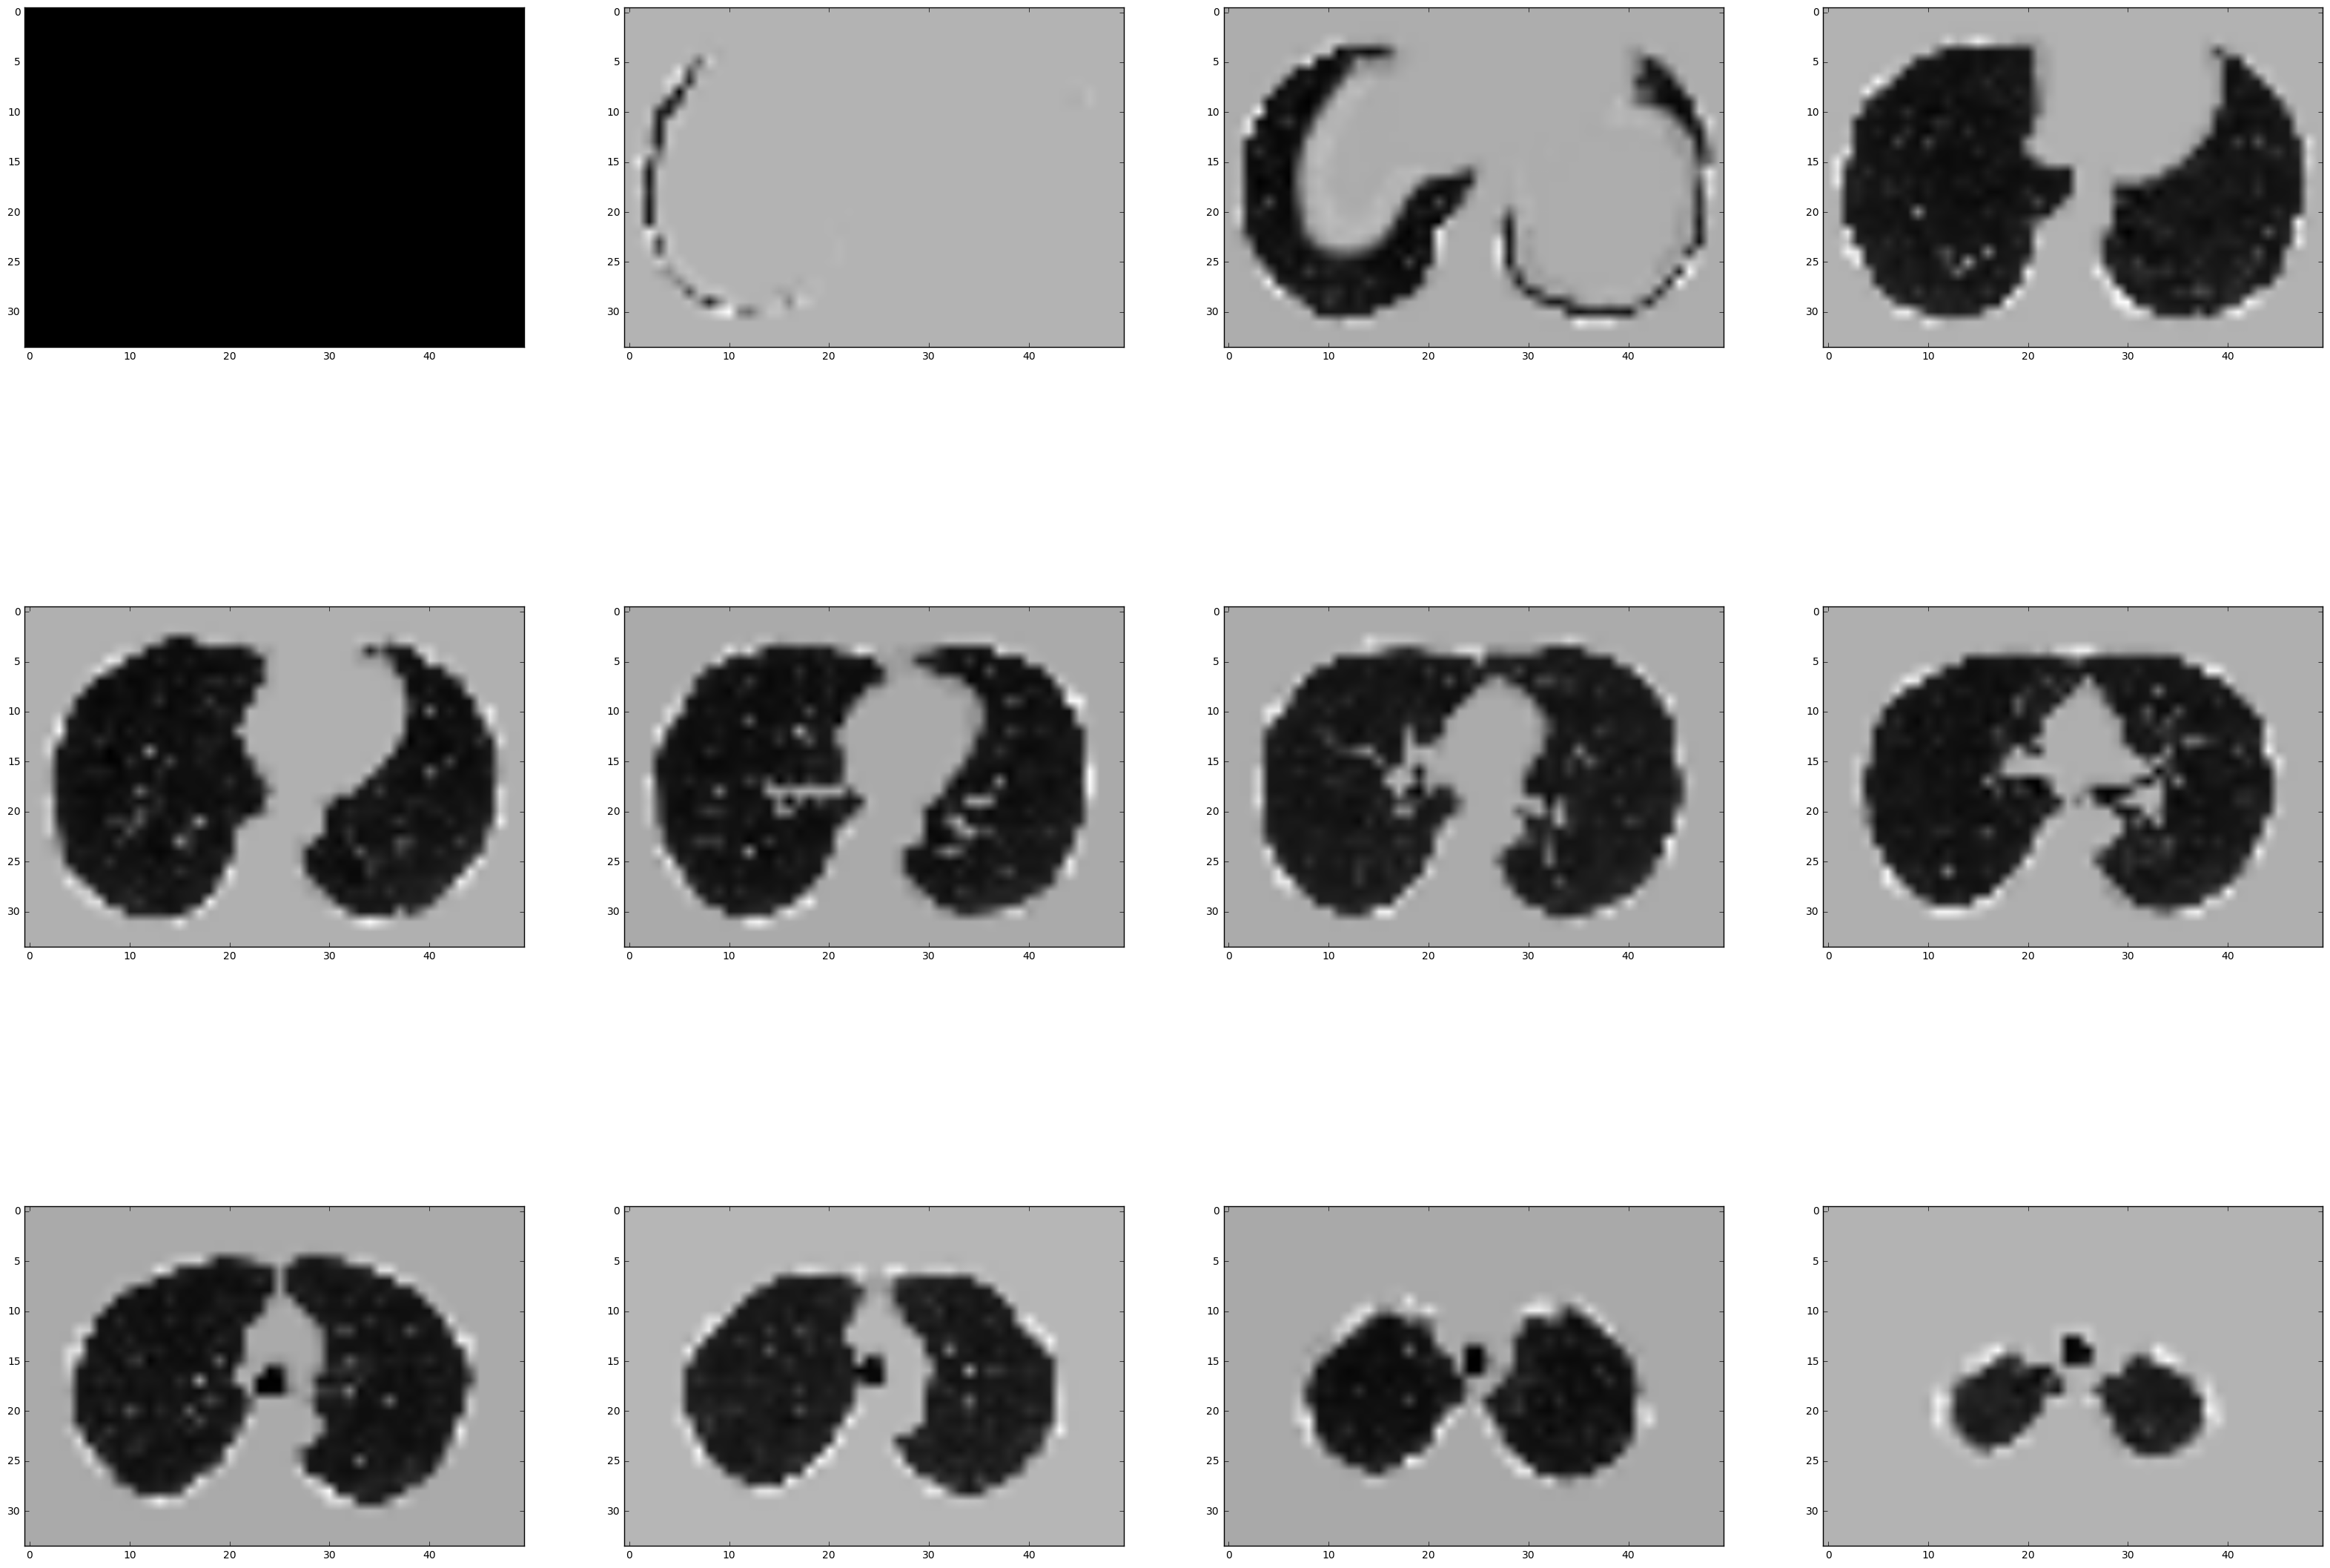

2017-02-21 04:23:13,482 INFO y=[ 1.  0.]
2017-02-21 04:23:13,483 INFO patient_index 37
2017-02-21 04:23:13,491 INFO x=


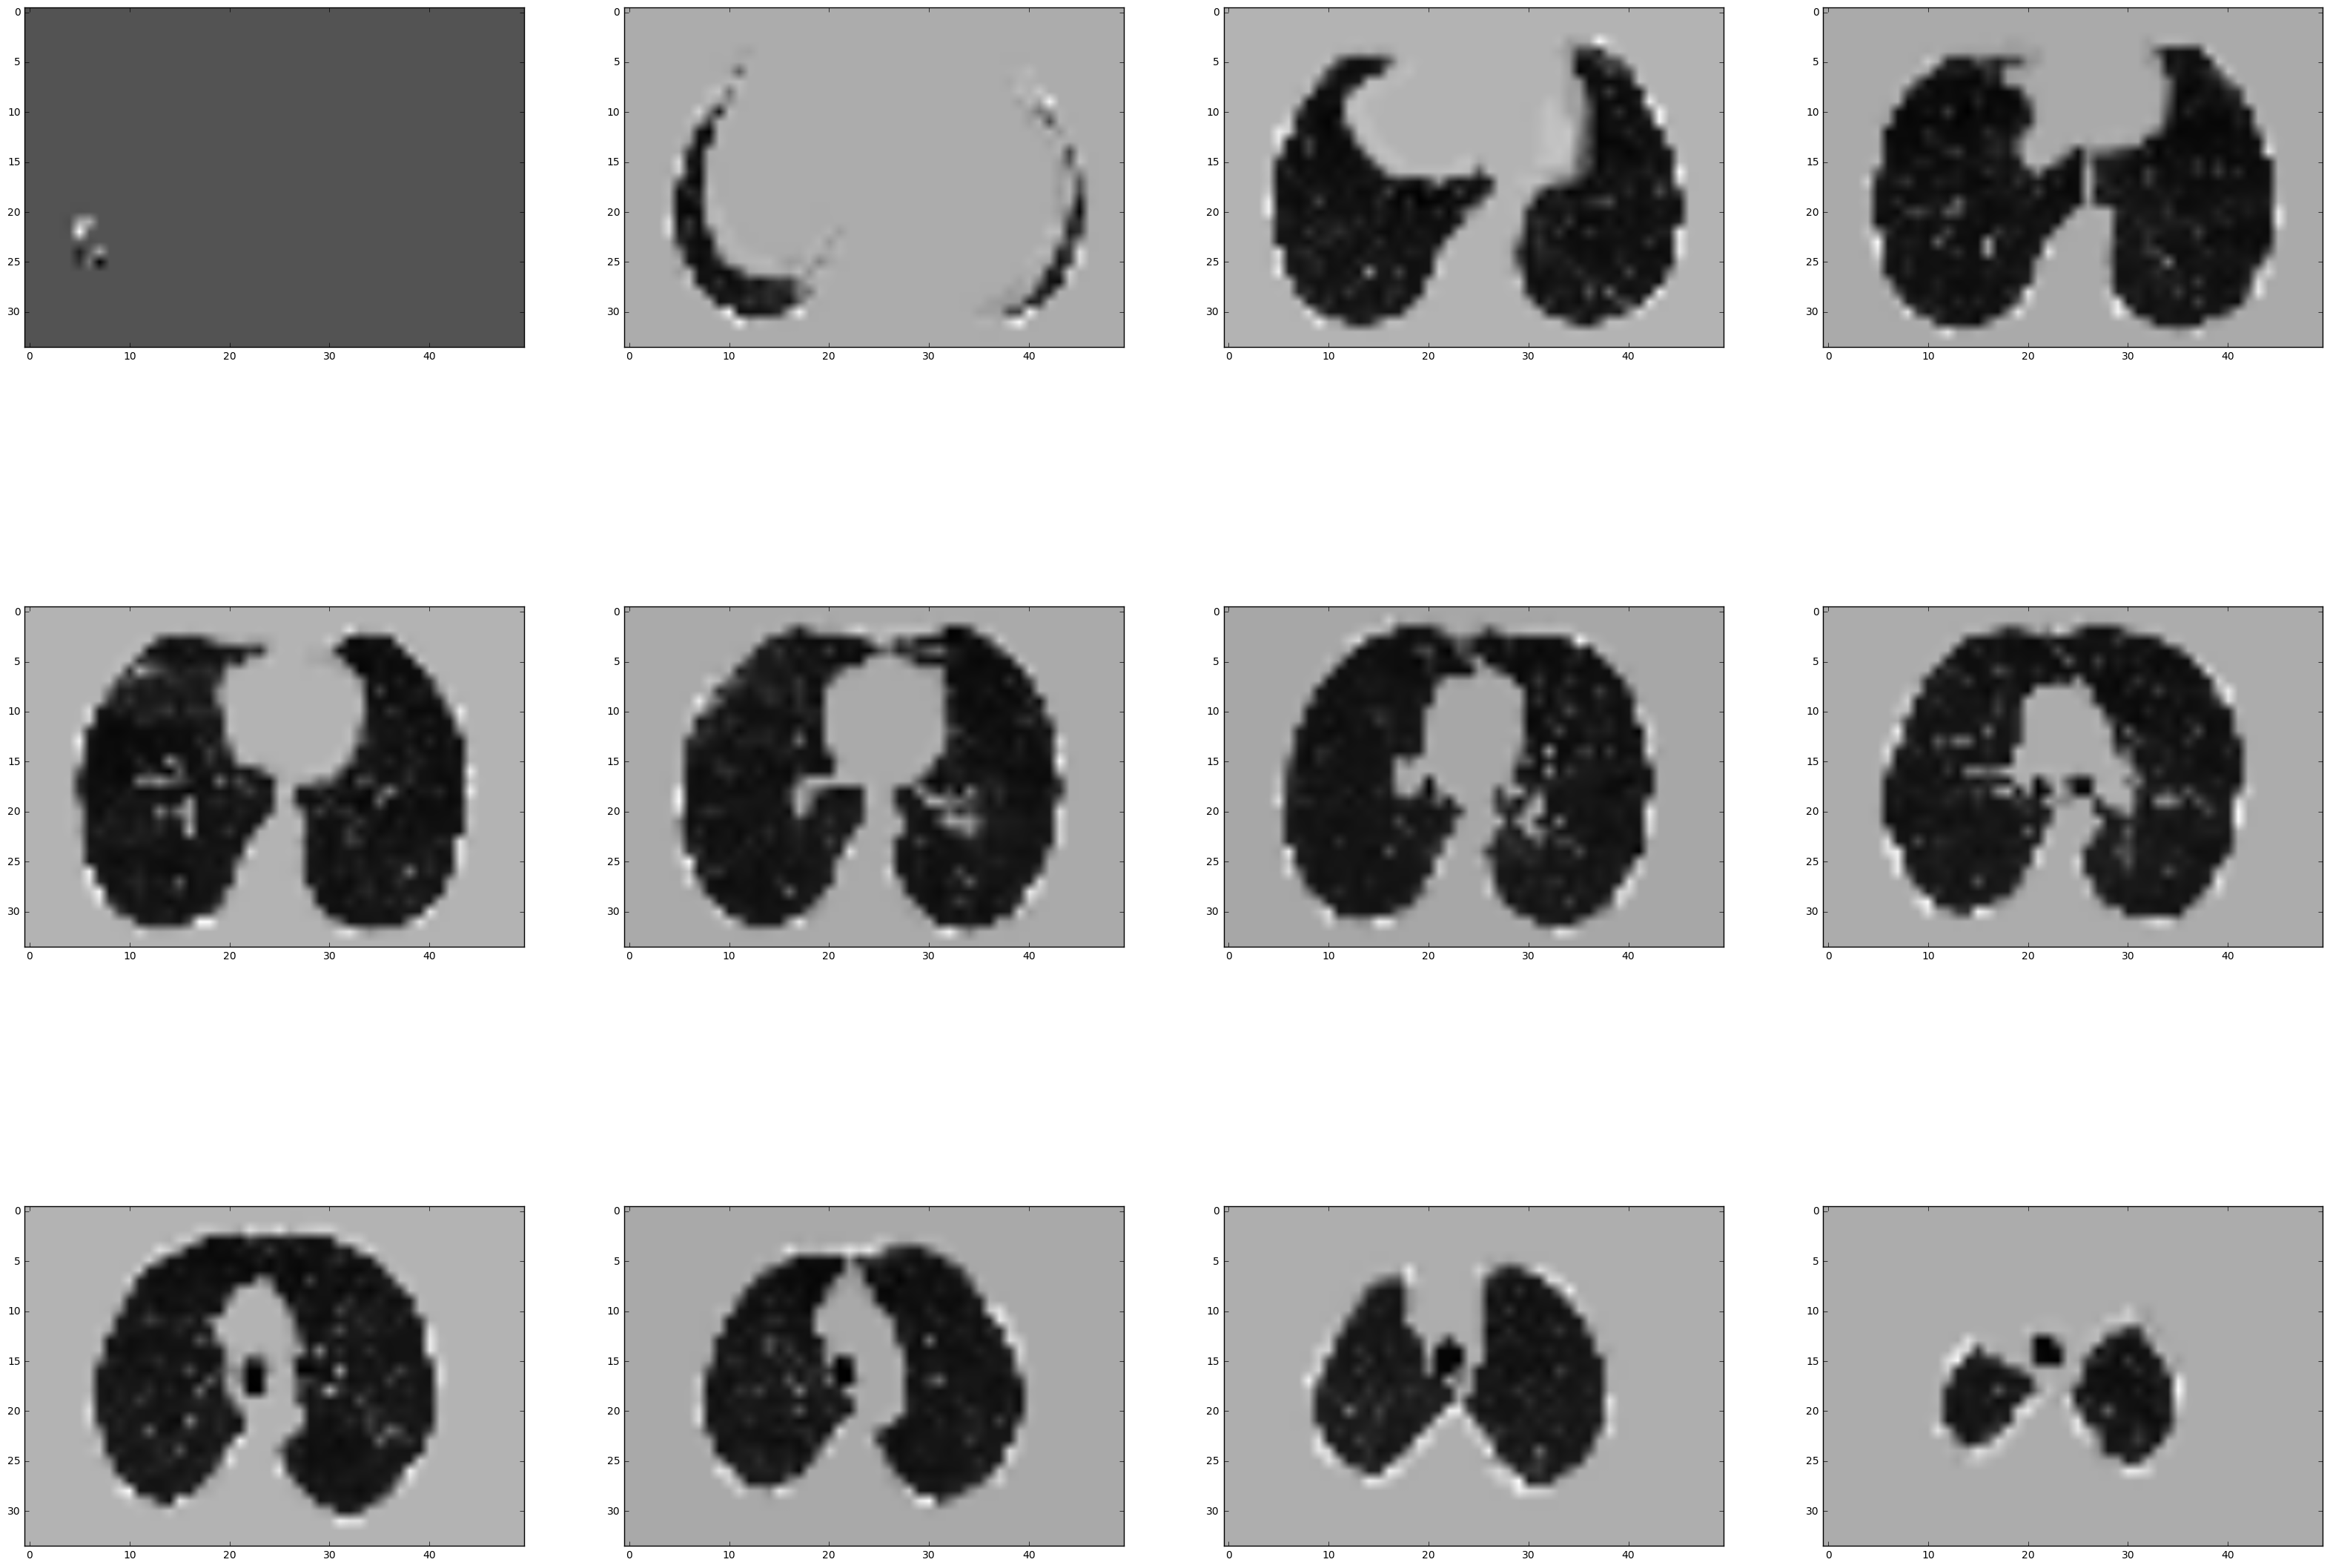

2017-02-21 04:23:19,686 INFO y=[ 1.  0.]
2017-02-21 04:23:19,688 INFO patient_index 73
2017-02-21 04:23:19,697 INFO x=


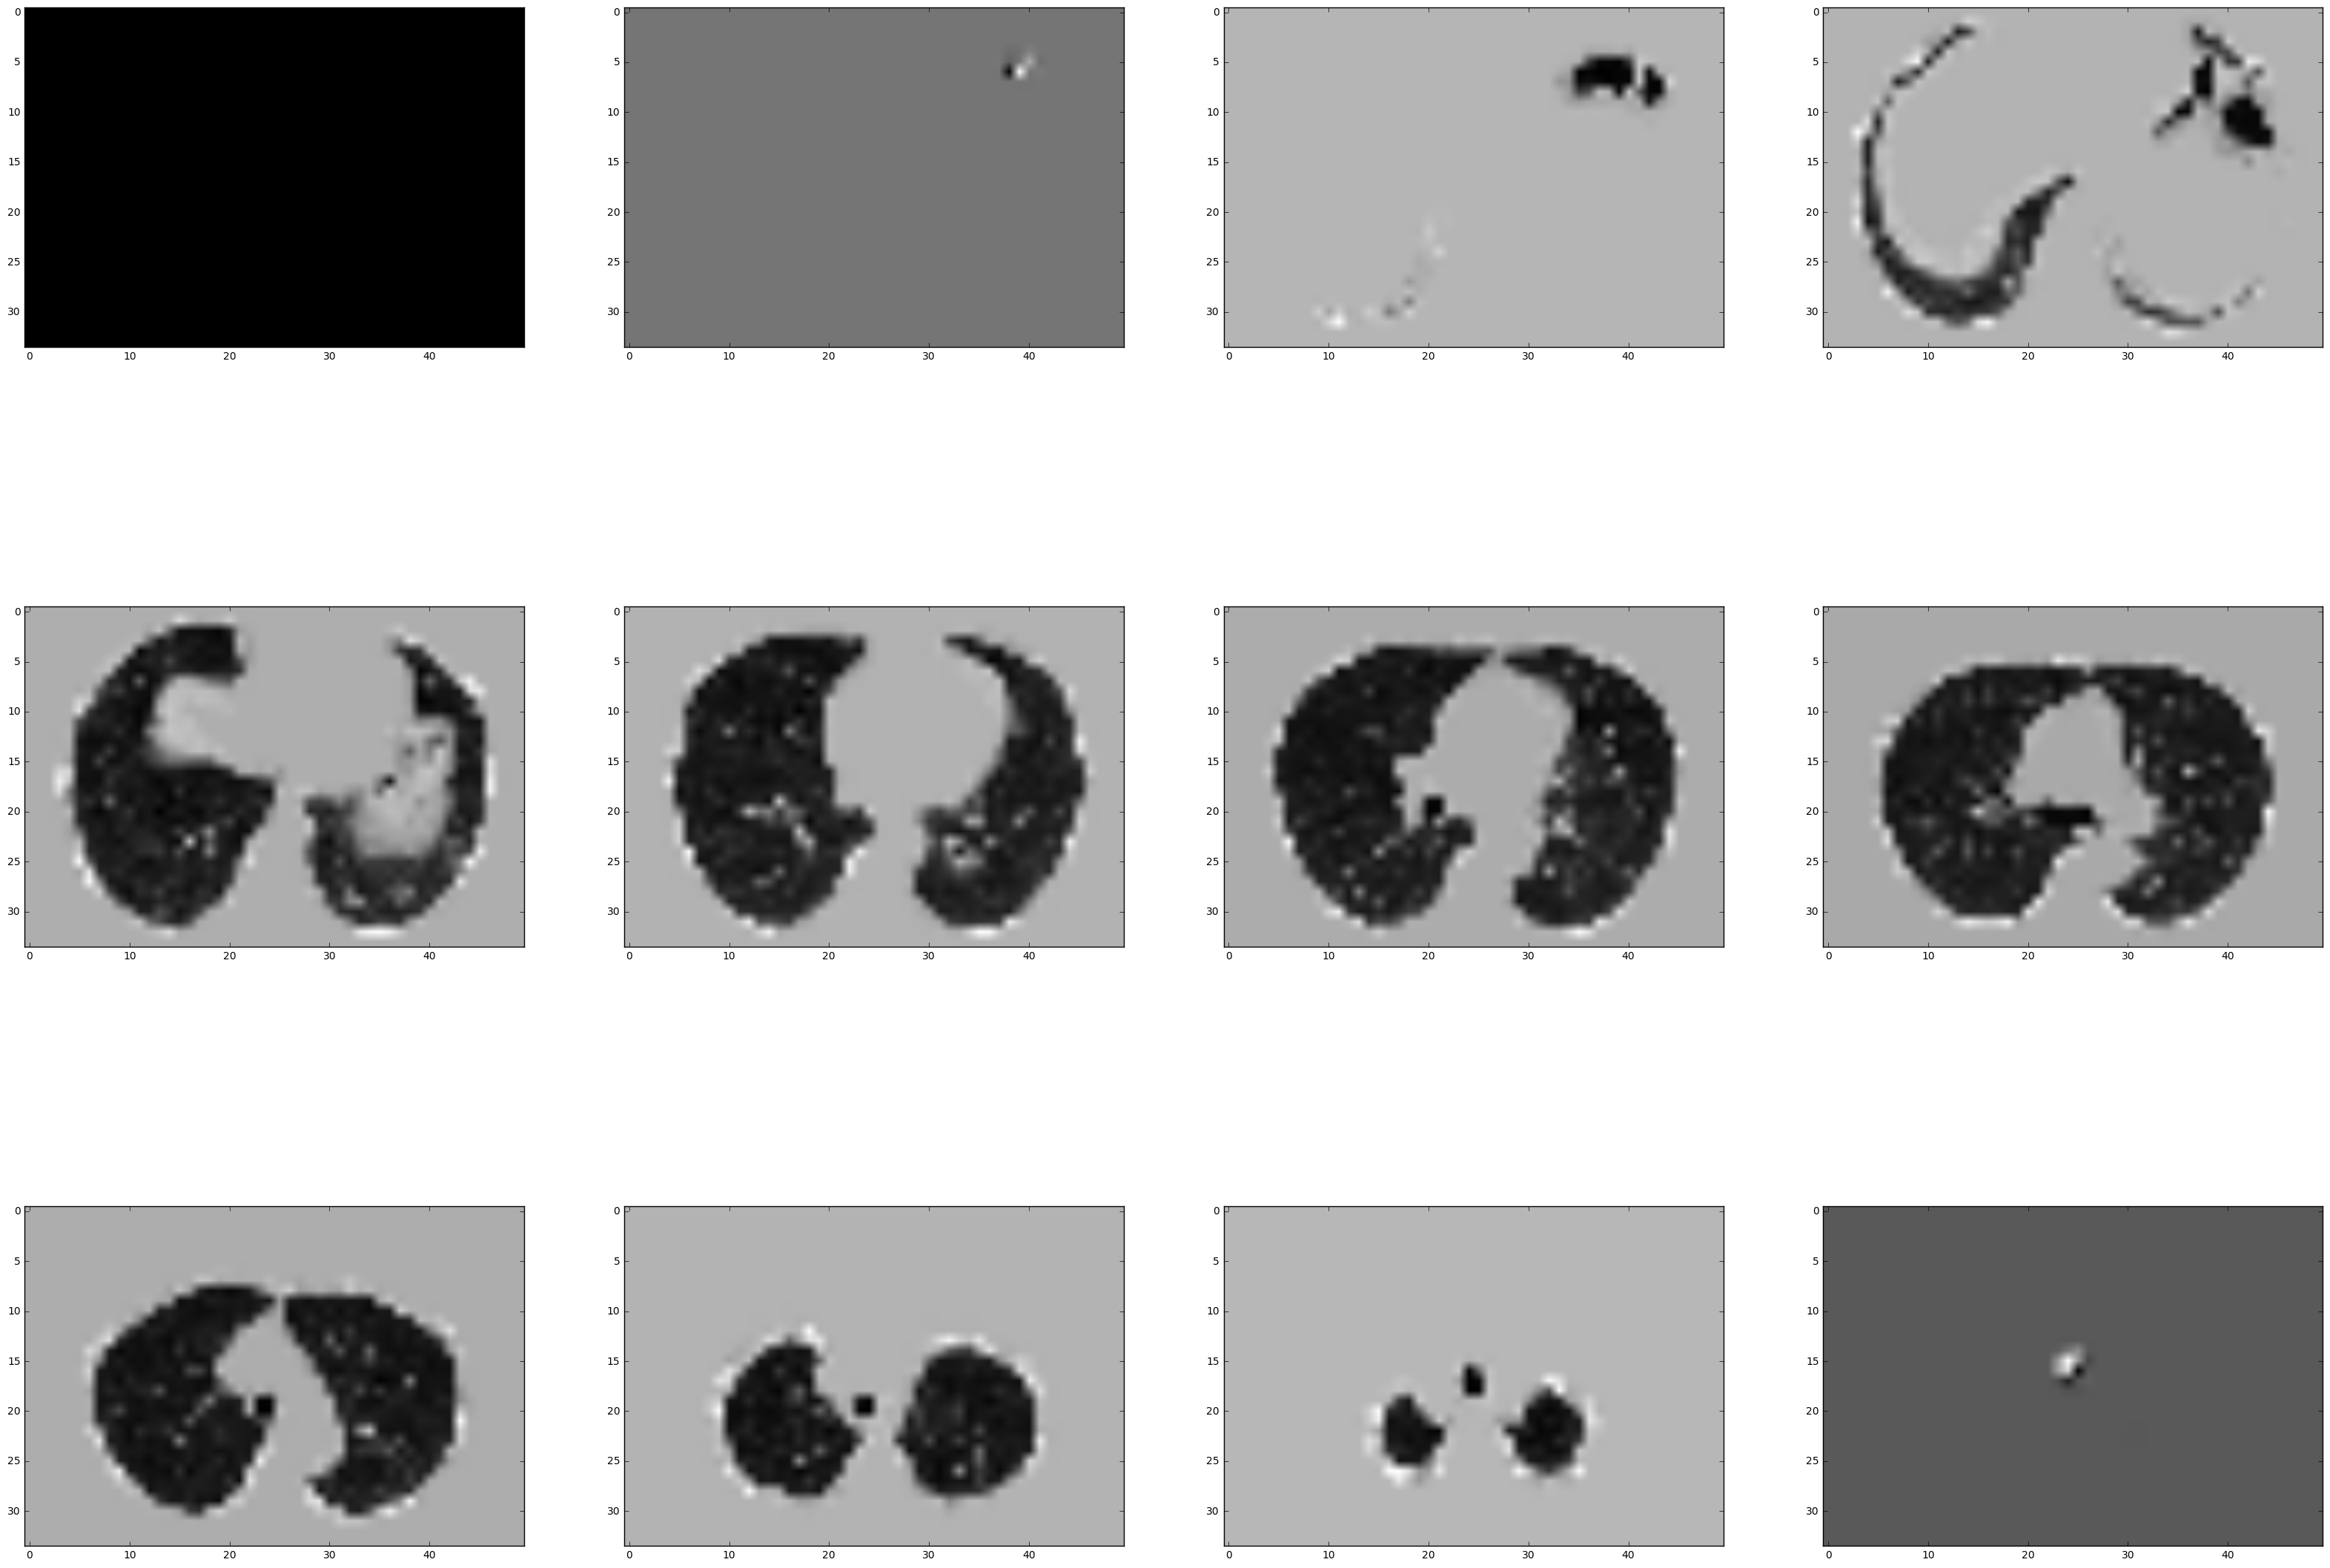

2017-02-21 04:23:25,097 INFO y=[ 1.  0.]
2017-02-21 04:23:25,098 INFO > [started] Distribute to validate dataset...
2017-02-21 04:23:25,099 DEBUG validate_qtty=10.0 qtty_label0=5.0 qtty_label1=5.0
2017-02-21 04:23:25,101 DEBUG input x shape=(10, 50, 34, 50, 1)
2017-02-21 04:23:25,103 INFO > [started] Resizing patient pixels 80...
2017-02-21 04:23:25,458 INFO > [done]    Resizing patient pixels 80 (355.466 ms)
2017-02-21 04:23:25,460 INFO > [started] Resizing patient pixels 81...
2017-02-21 04:23:25,790 INFO > [done]    Resizing patient pixels 81 (330.048 ms)
2017-02-21 04:23:25,792 INFO > [started] Resizing patient pixels 83...
2017-02-21 04:23:26,117 INFO > [done]    Resizing patient pixels 83 (324.612 ms)
2017-02-21 04:23:26,124 INFO > [started] Resizing patient pixels 84...
2017-02-21 04:23:26,504 INFO > [done]    Resizing patient pixels 84 (380.219 ms)
2017-02-21 04:23:26,506 INFO > [started] Resizing patient pixels 85...
2017-02-21 04:23:26,830 INFO > [done]    Resizing patient pi

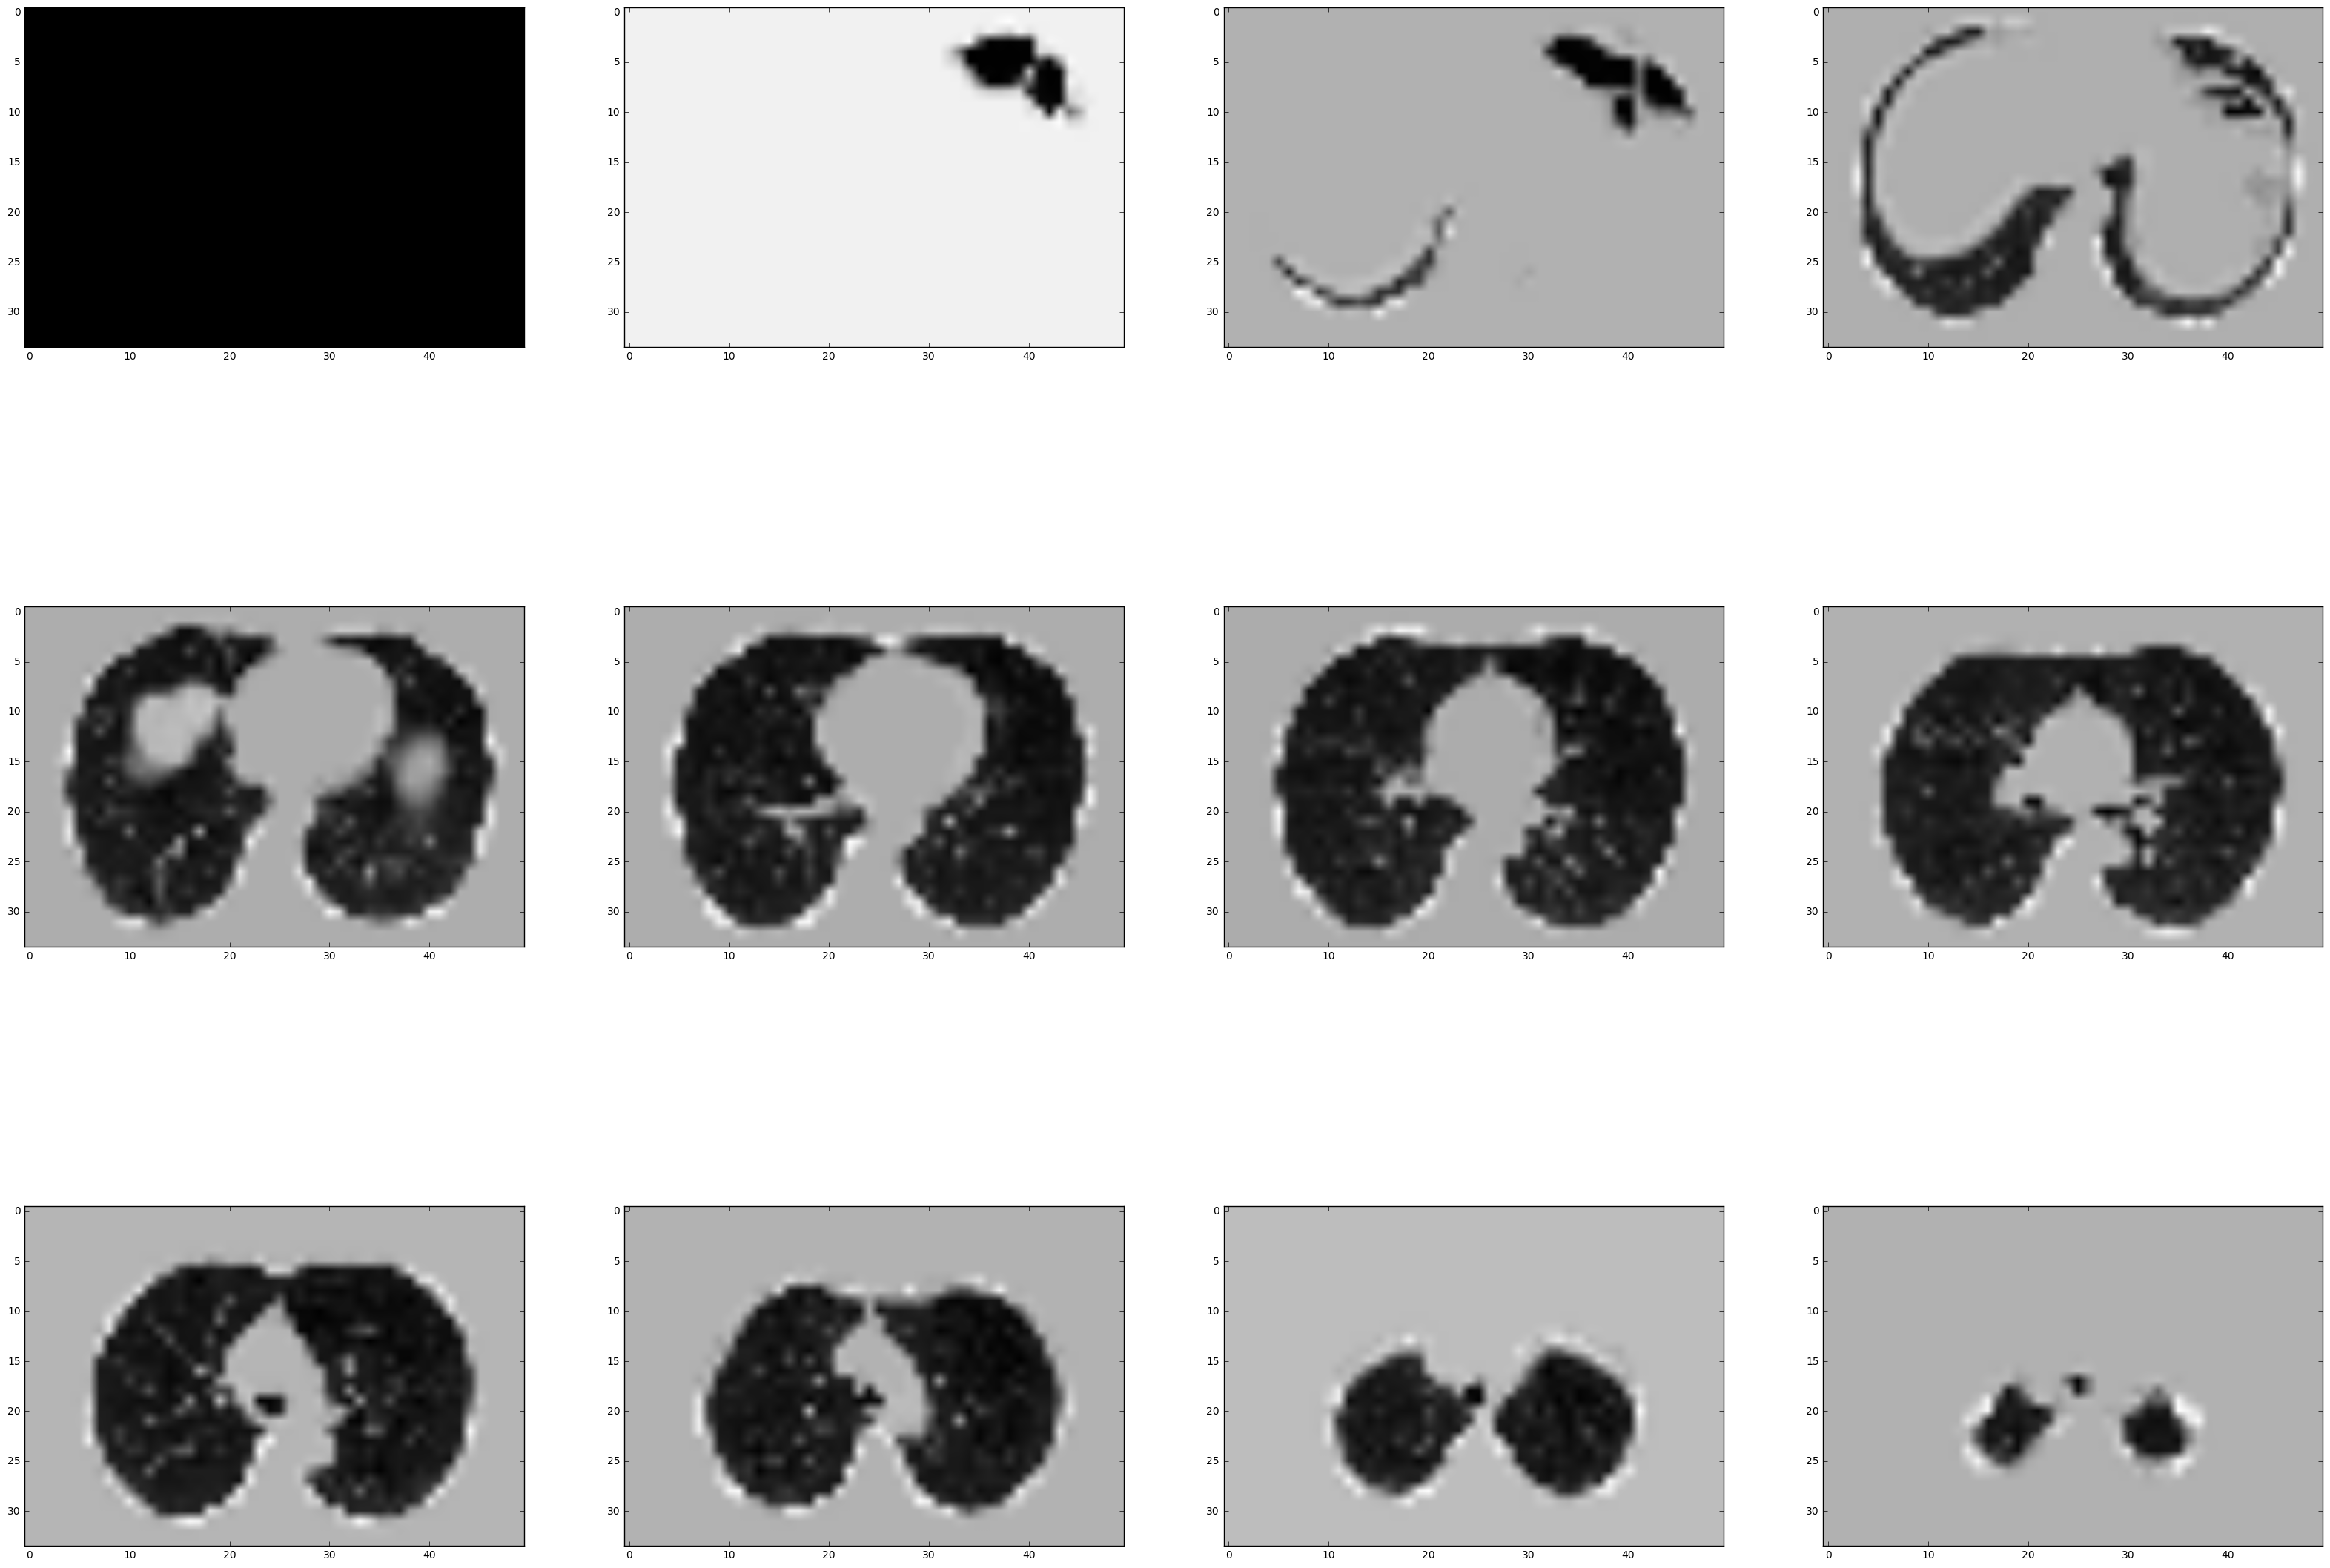

2017-02-21 04:23:33,458 INFO y=[ 1.  0.]
2017-02-21 04:23:33,463 INFO patient_index 3
2017-02-21 04:23:33,464 INFO x=


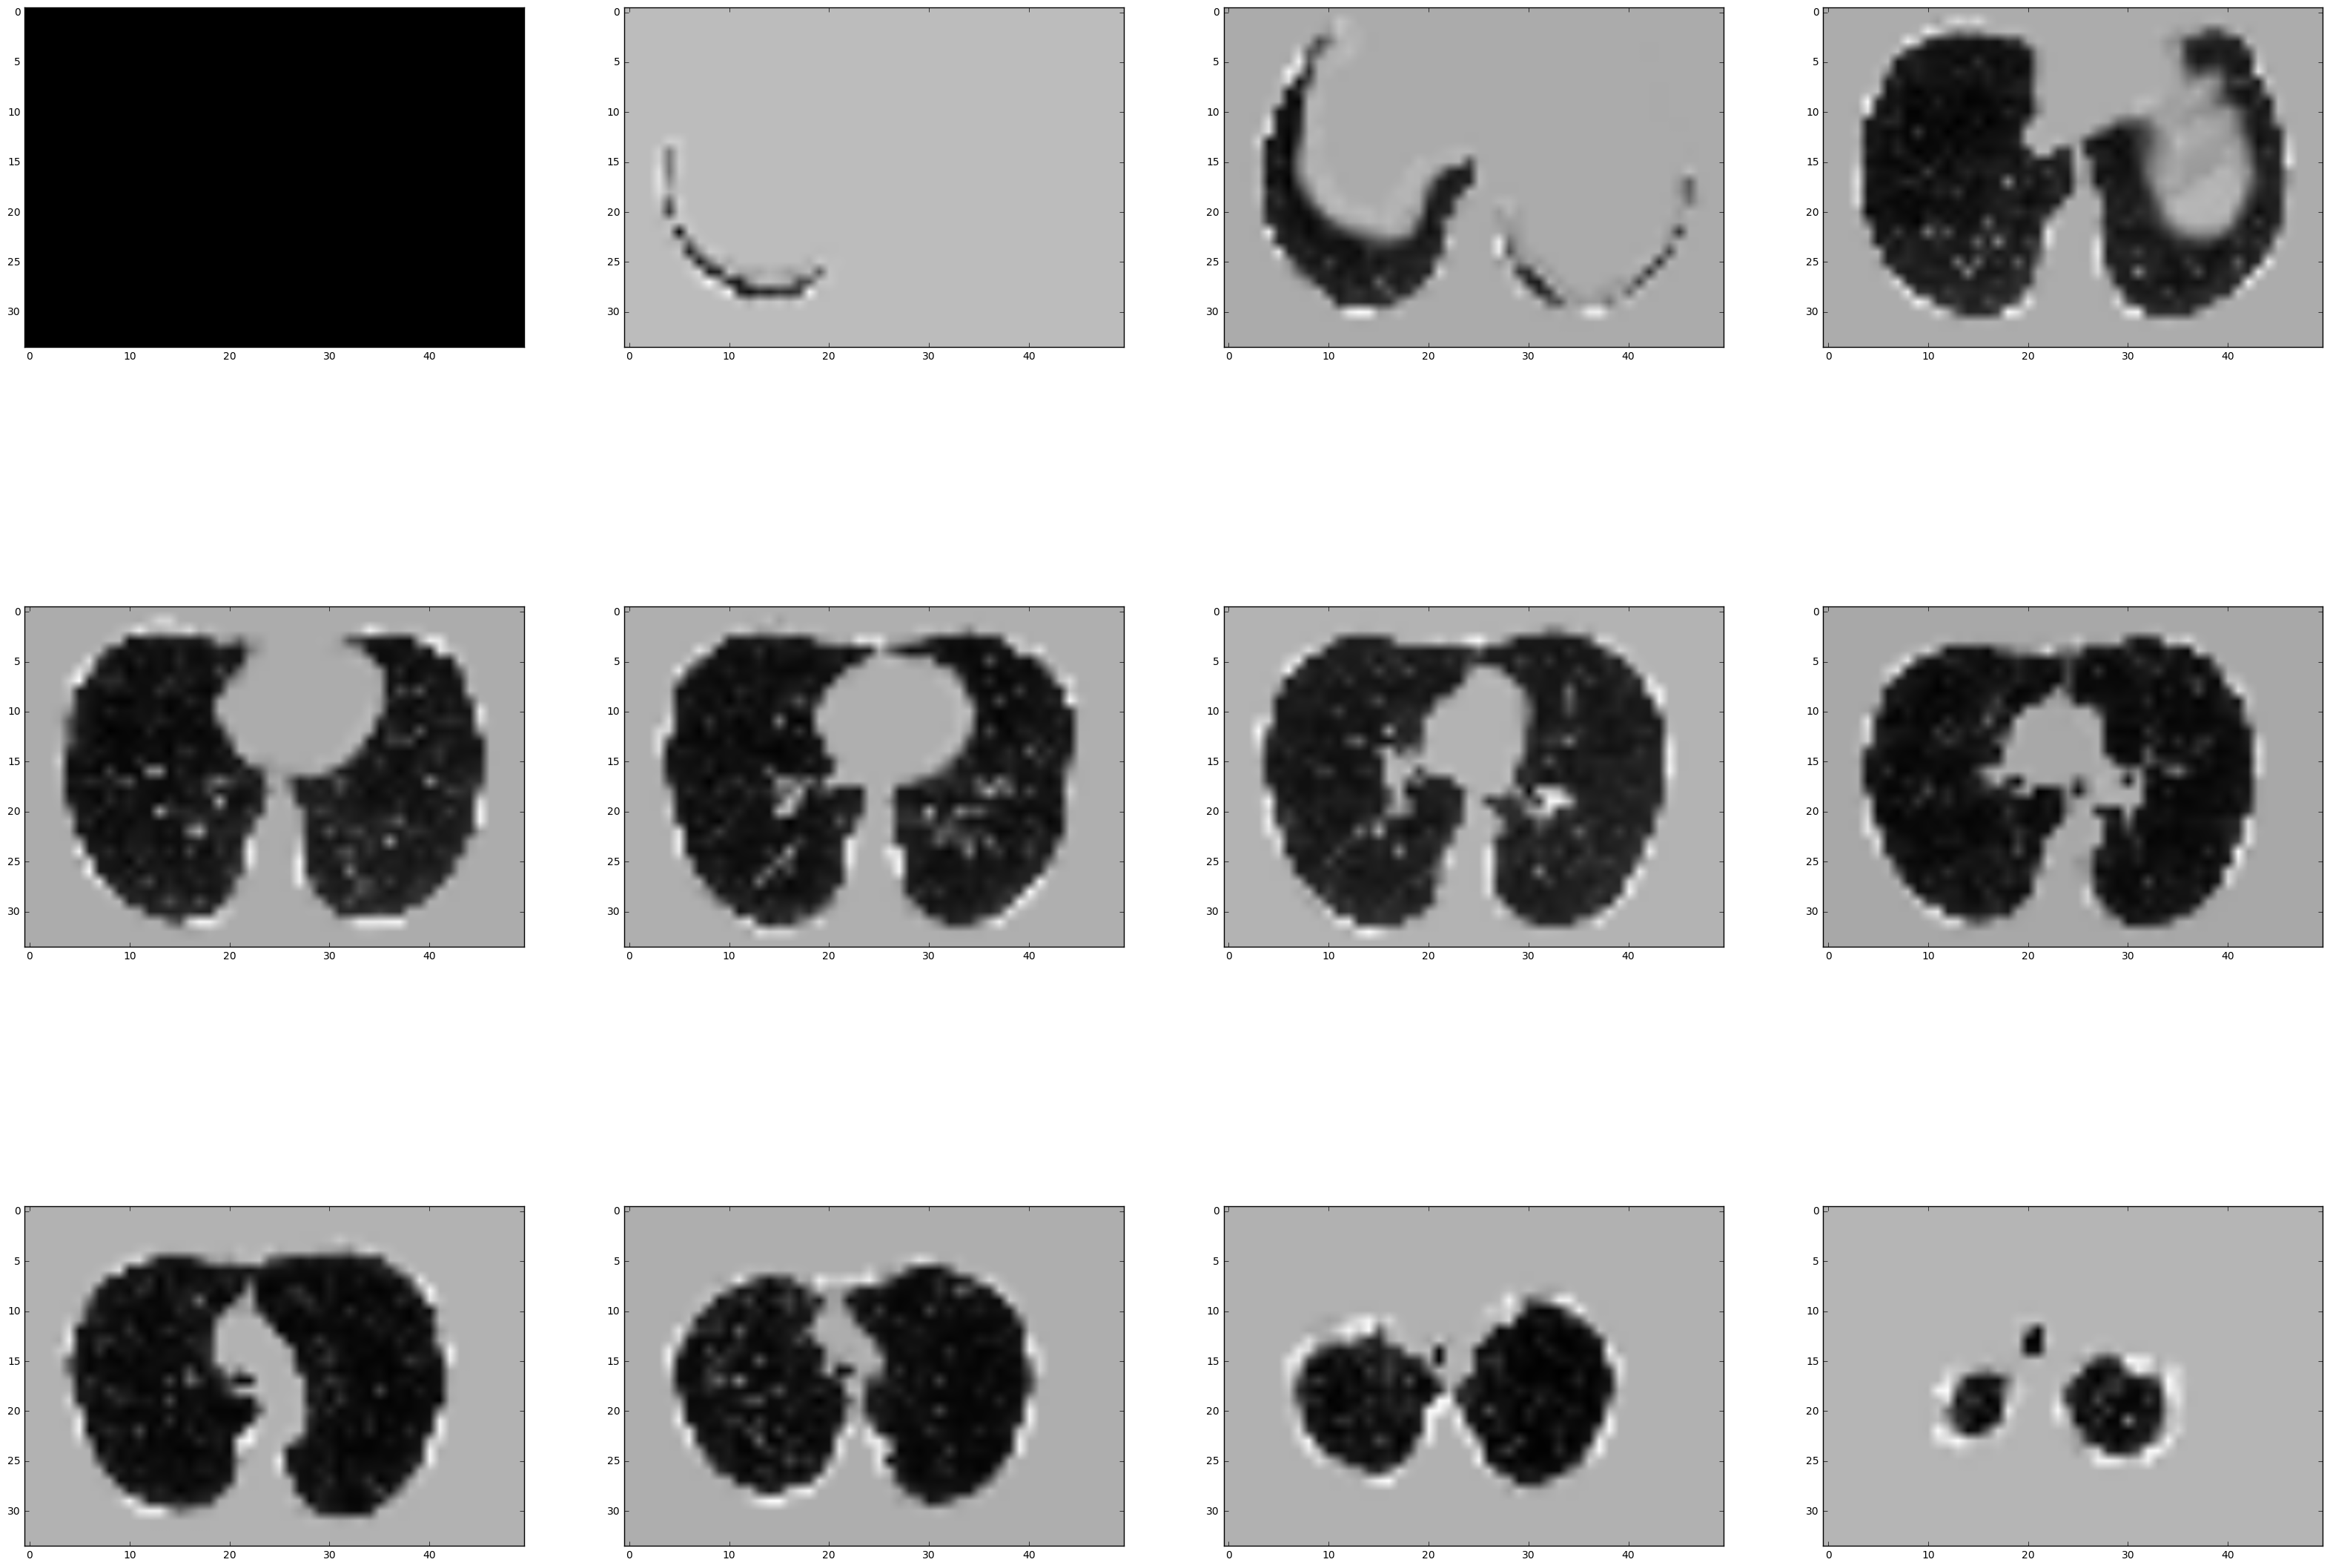

2017-02-21 04:23:38,807 INFO y=[ 1.  0.]
2017-02-21 04:23:38,808 INFO patient_index 7
2017-02-21 04:23:38,809 INFO x=


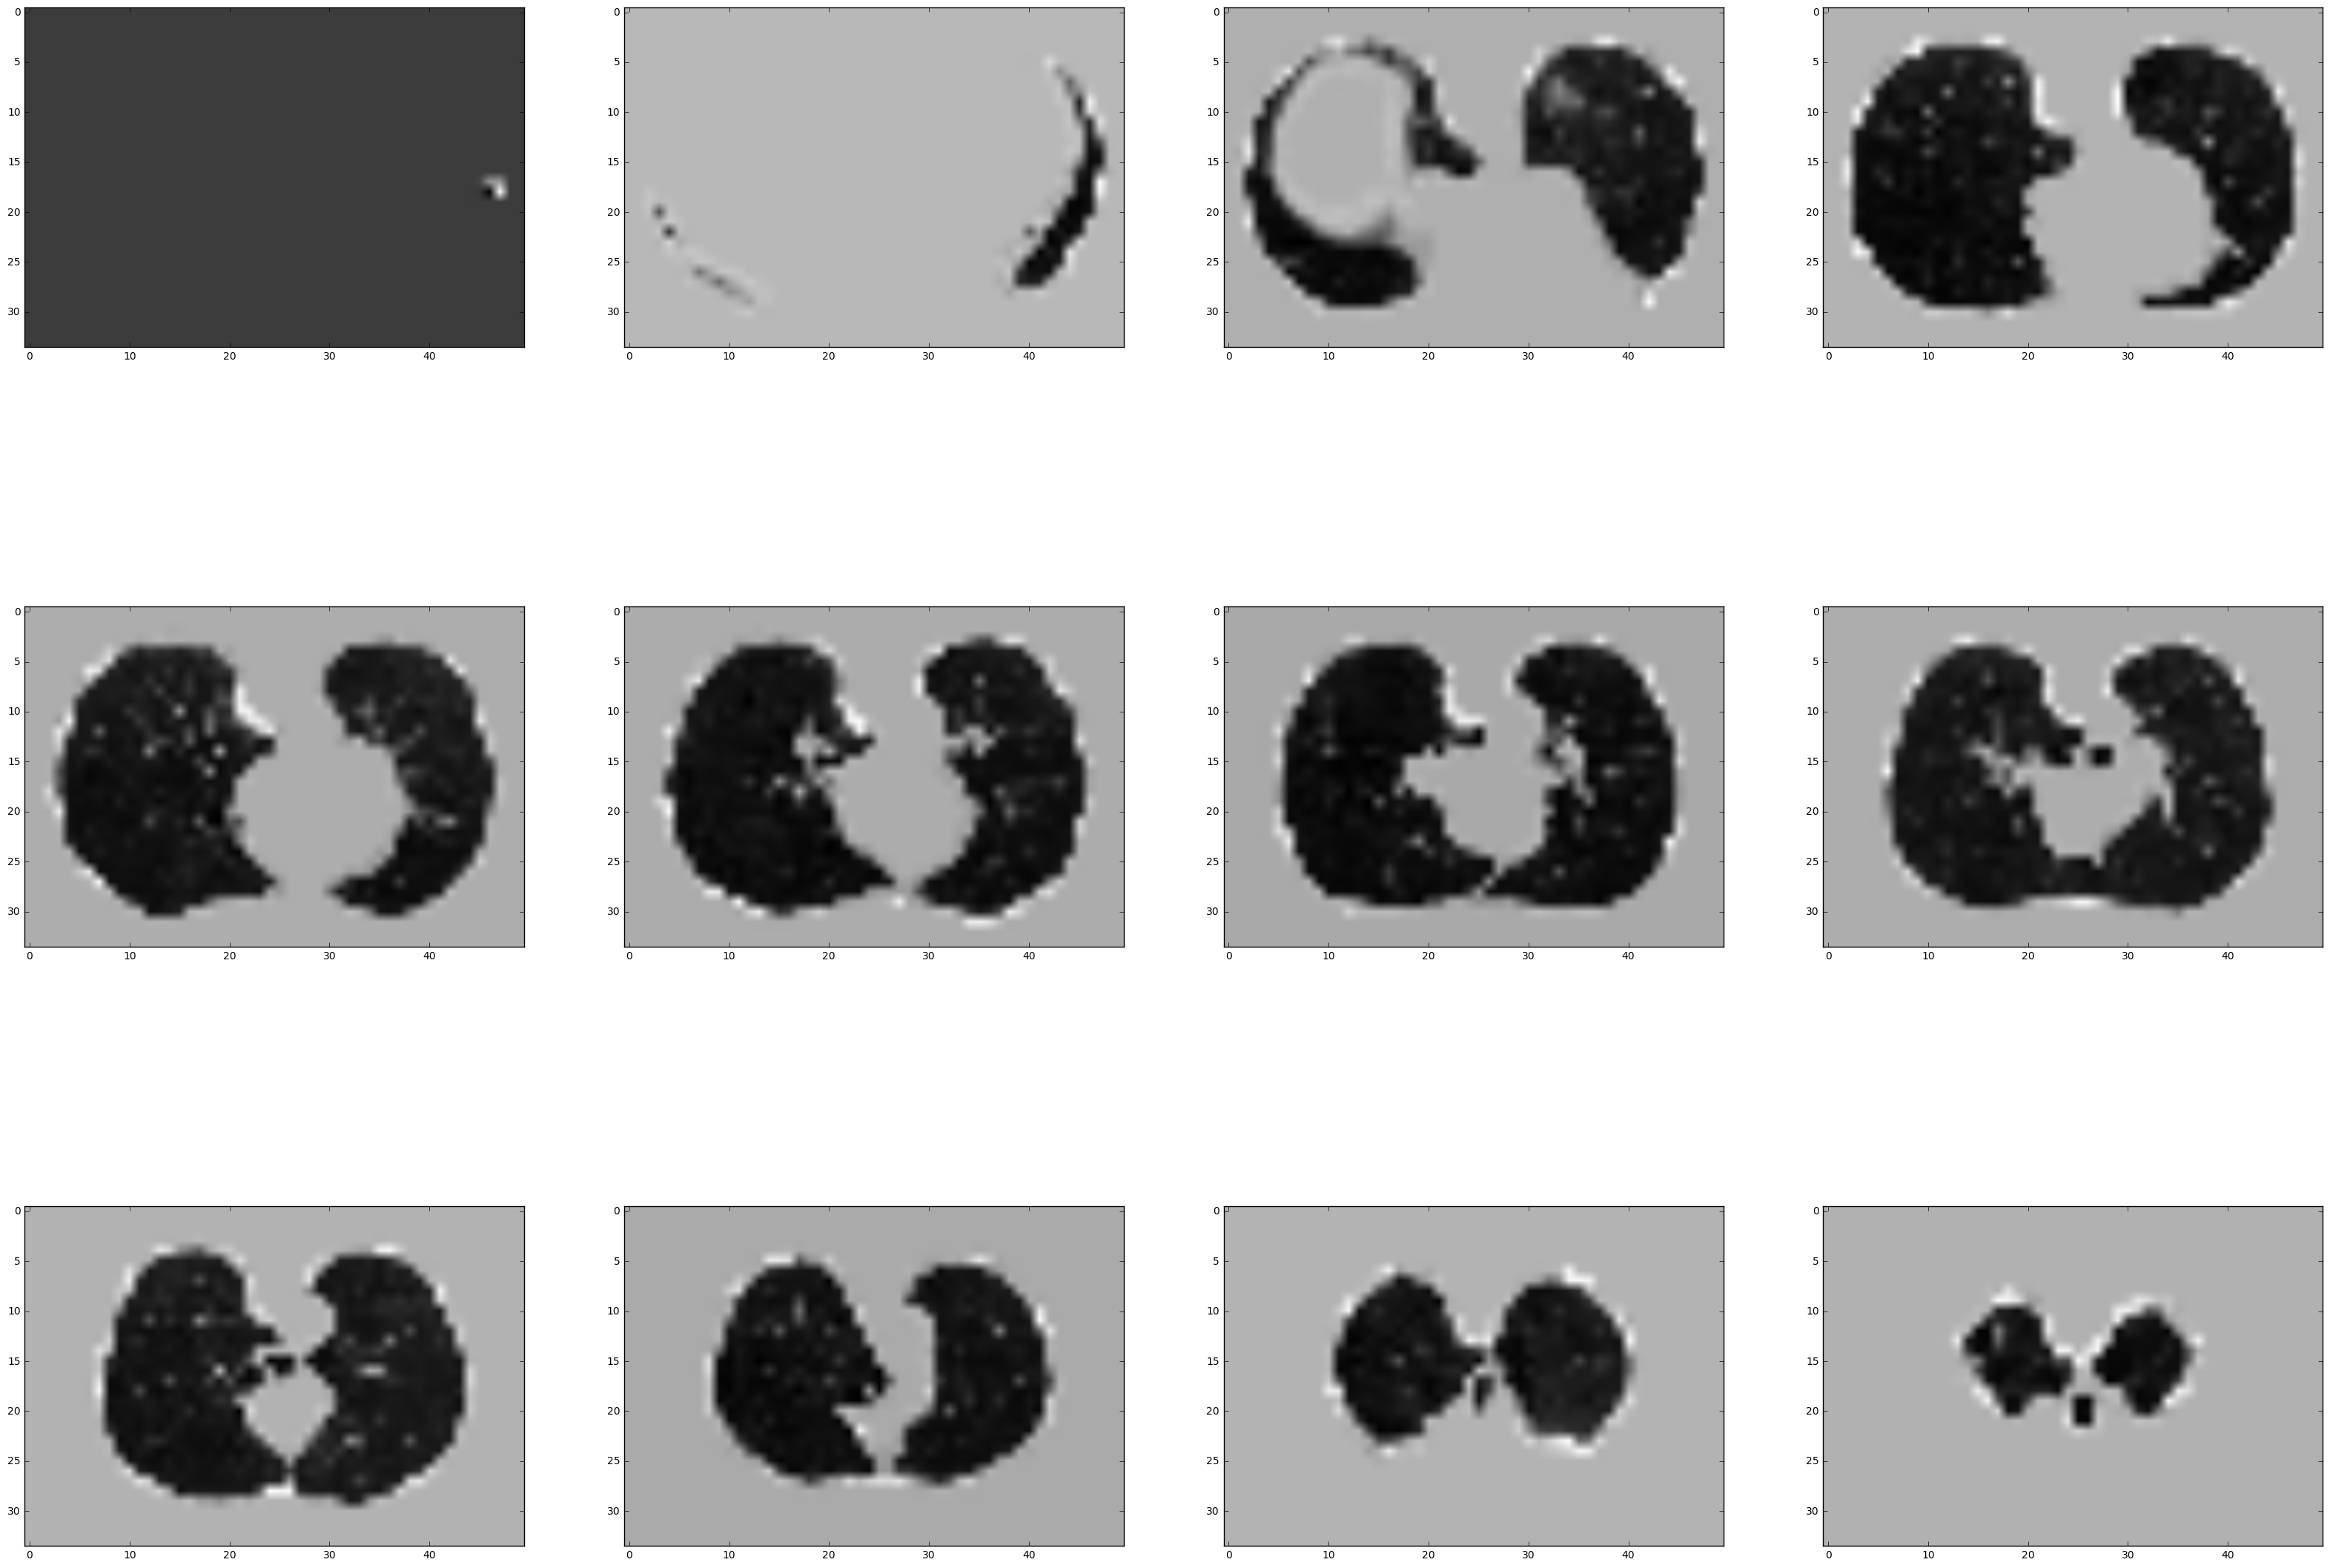

2017-02-21 04:23:43,875 INFO y=[ 0.  1.]
2017-02-21 04:23:43,878 INFO > [started] Distribute to test dataset...
2017-02-21 04:23:43,879 DEBUG test_qtty=111.0 qtty_label0=111.0 qtty_label1=111.0
2017-02-21 04:23:43,881 DEBUG input x shape=(111, 50, 34, 50, 1)
2017-02-21 04:23:43,884 INFO > [started] Resizing patient pixels 86...
2017-02-21 04:23:44,192 INFO > [done]    Resizing patient pixels 86 (307.904 ms)
2017-02-21 04:23:44,194 INFO > [started] Resizing patient pixels 87...
2017-02-21 04:23:44,491 INFO > [done]    Resizing patient pixels 87 (296.507 ms)
2017-02-21 04:23:44,493 INFO > [started] Resizing patient pixels 88...
2017-02-21 04:23:44,815 INFO > [done]    Resizing patient pixels 88 (322.176 ms)
2017-02-21 04:23:44,817 INFO > [started] Resizing patient pixels 89...
2017-02-21 04:23:45,132 INFO > [done]    Resizing patient pixels 89 (314.893 ms)
2017-02-21 04:23:45,134 INFO > [started] Resizing patient pixels 90...
2017-02-21 04:23:45,479 INFO > [done]    Resizing patient pixe

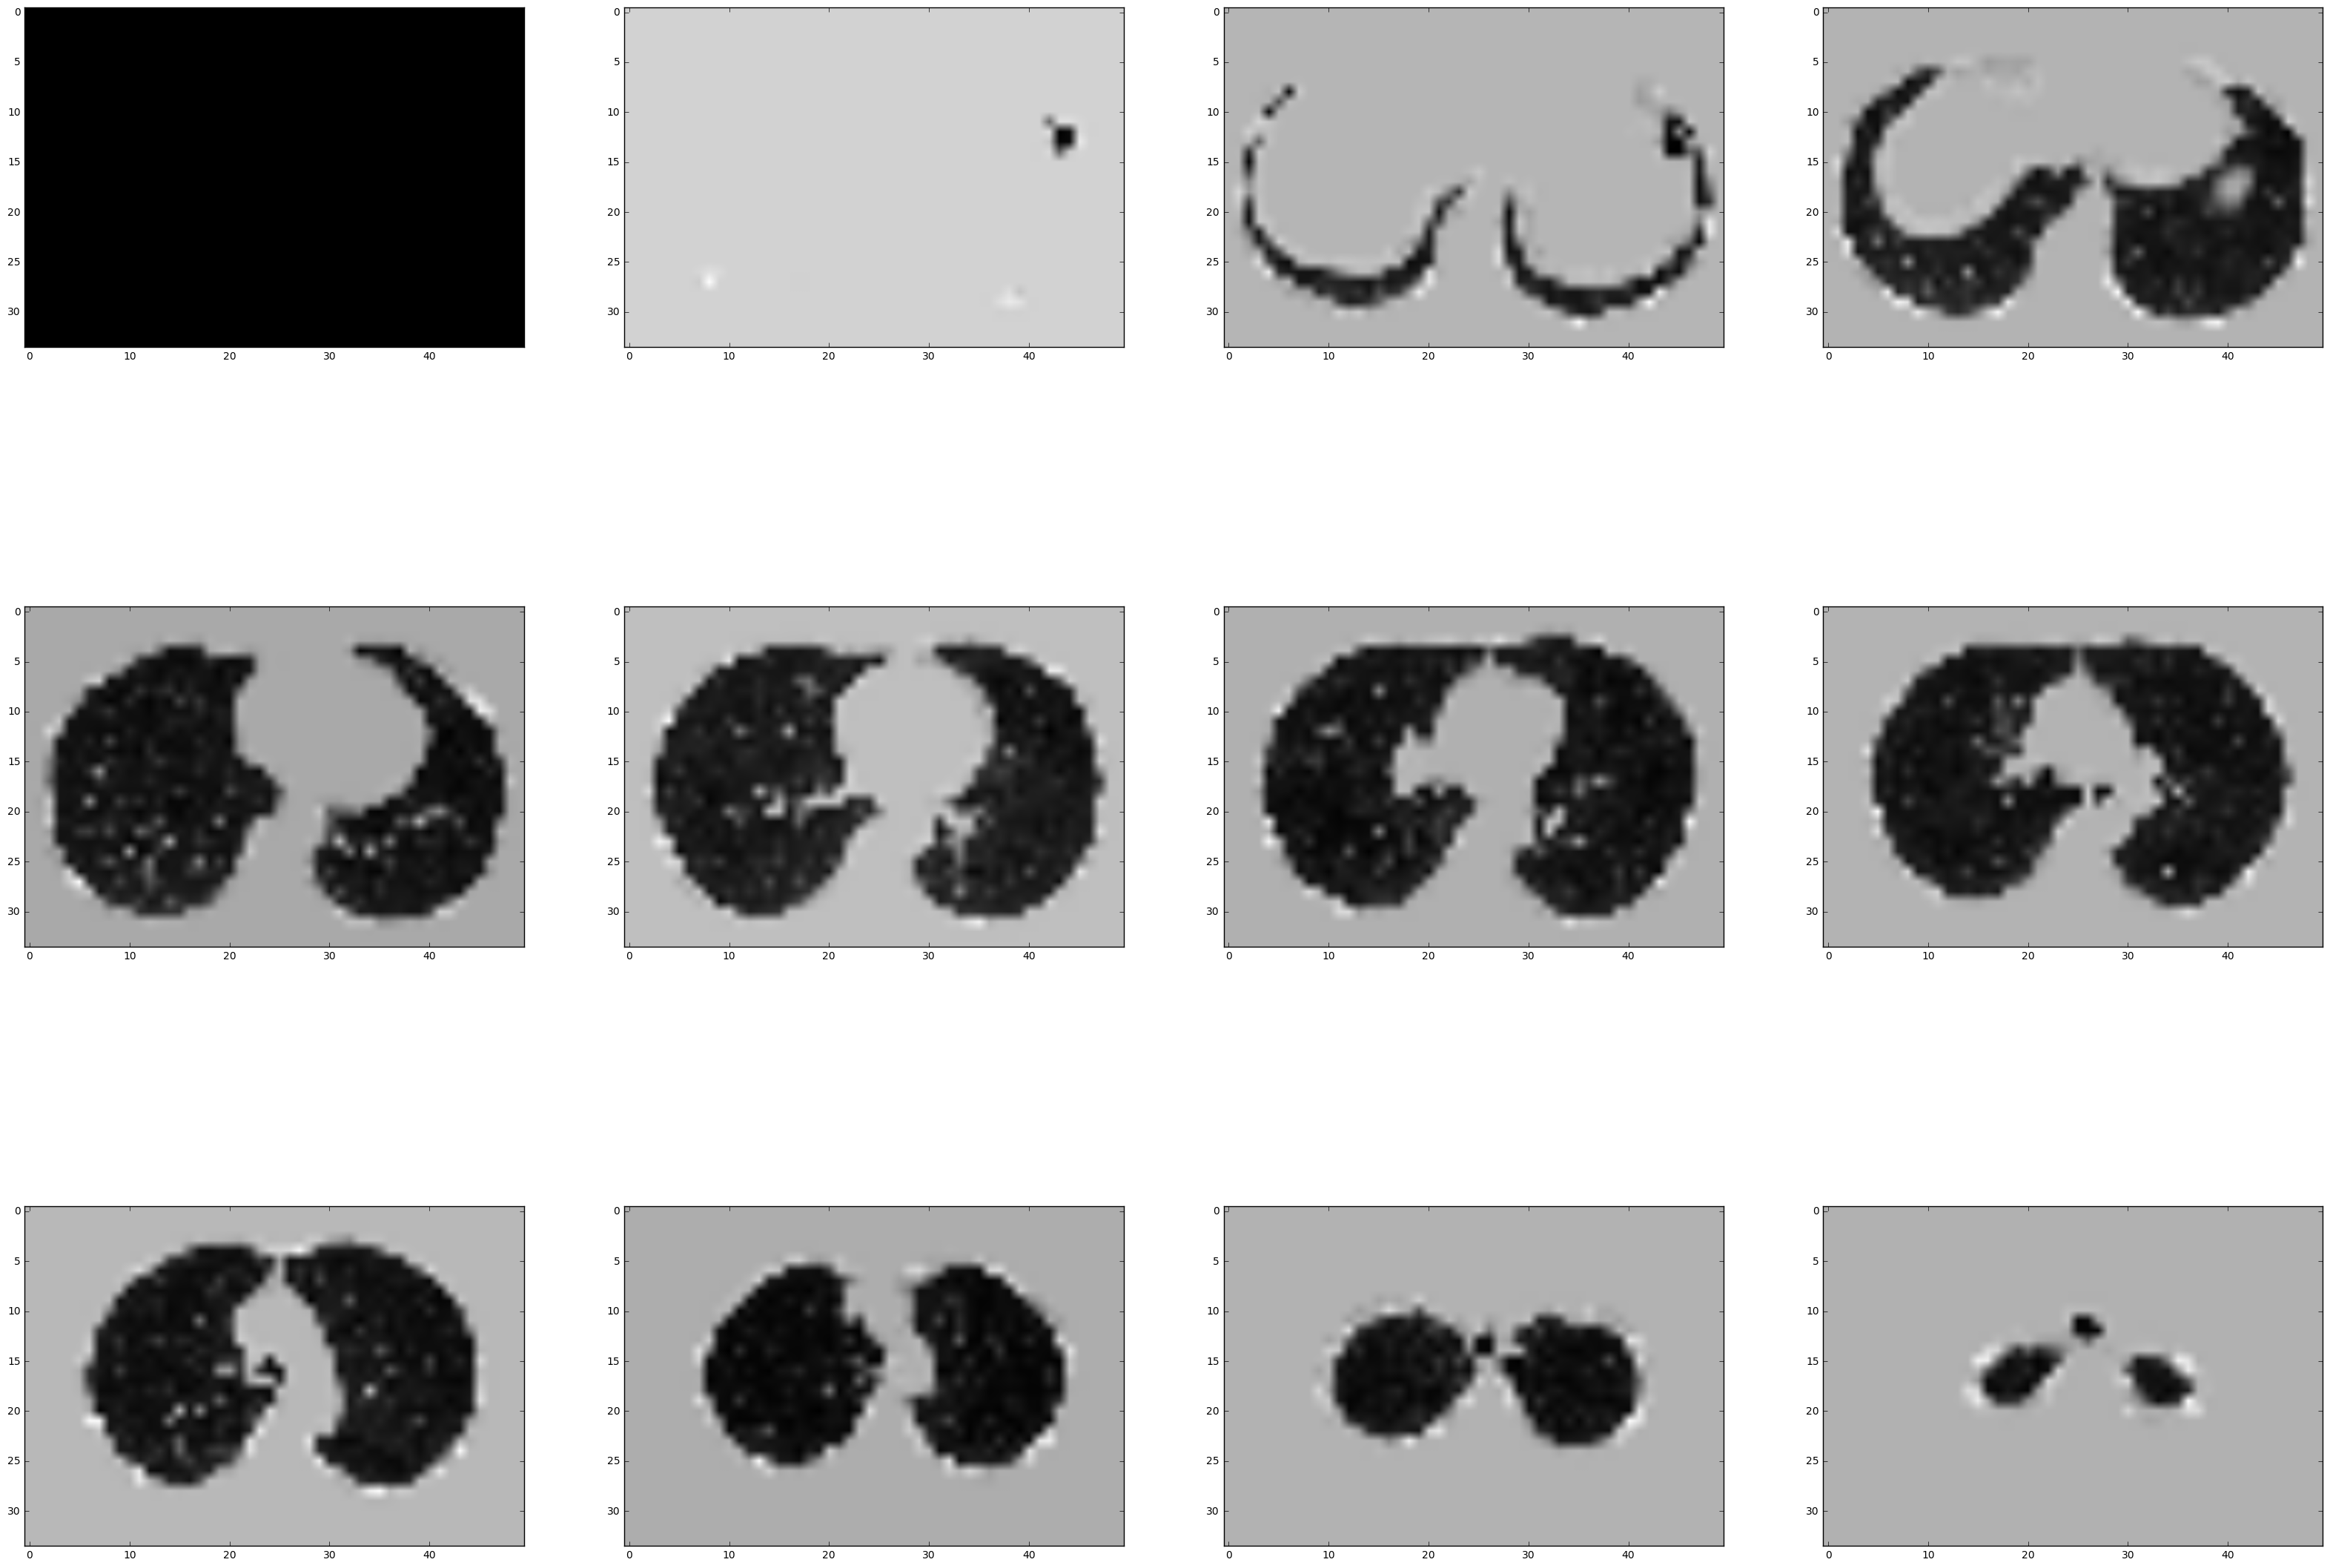

2017-02-21 04:24:30,649 INFO y=[ 1.  0.]
2017-02-21 04:24:30,651 INFO patient_index 37
2017-02-21 04:24:30,652 INFO x=


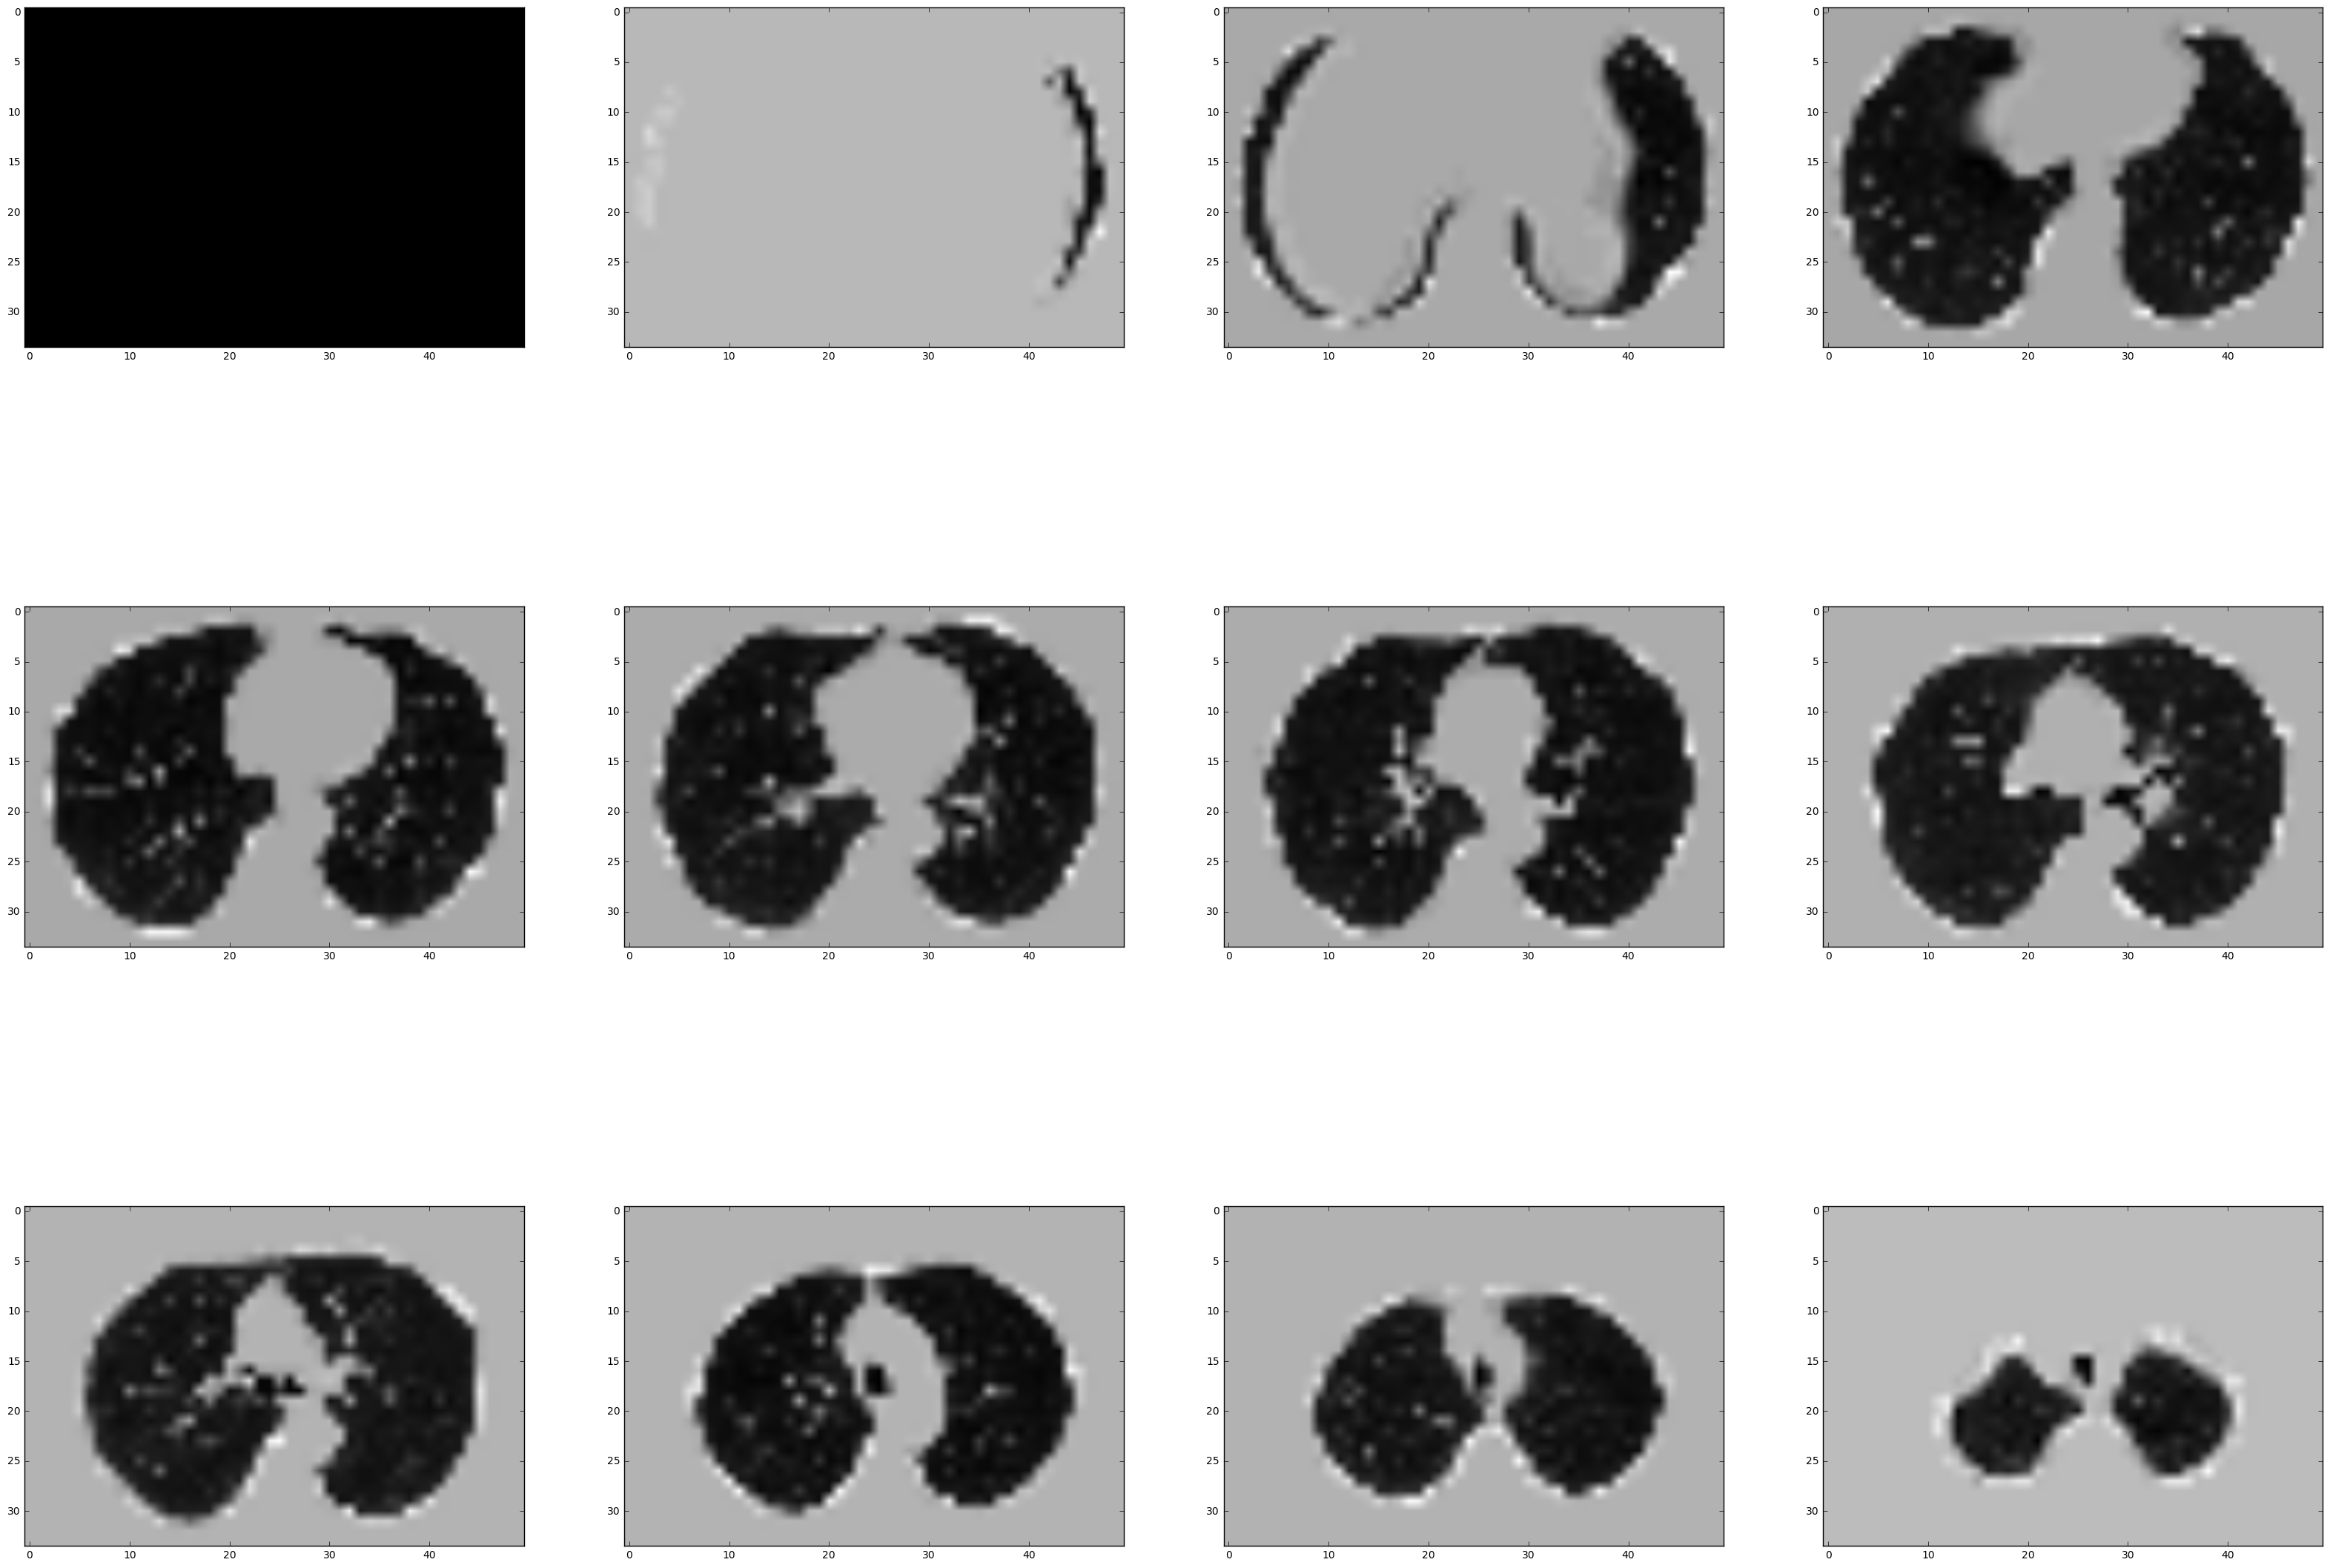

2017-02-21 04:24:35,613 INFO y=[ 1.  0.]
2017-02-21 04:24:35,618 INFO patient_index 74
2017-02-21 04:24:35,618 INFO x=


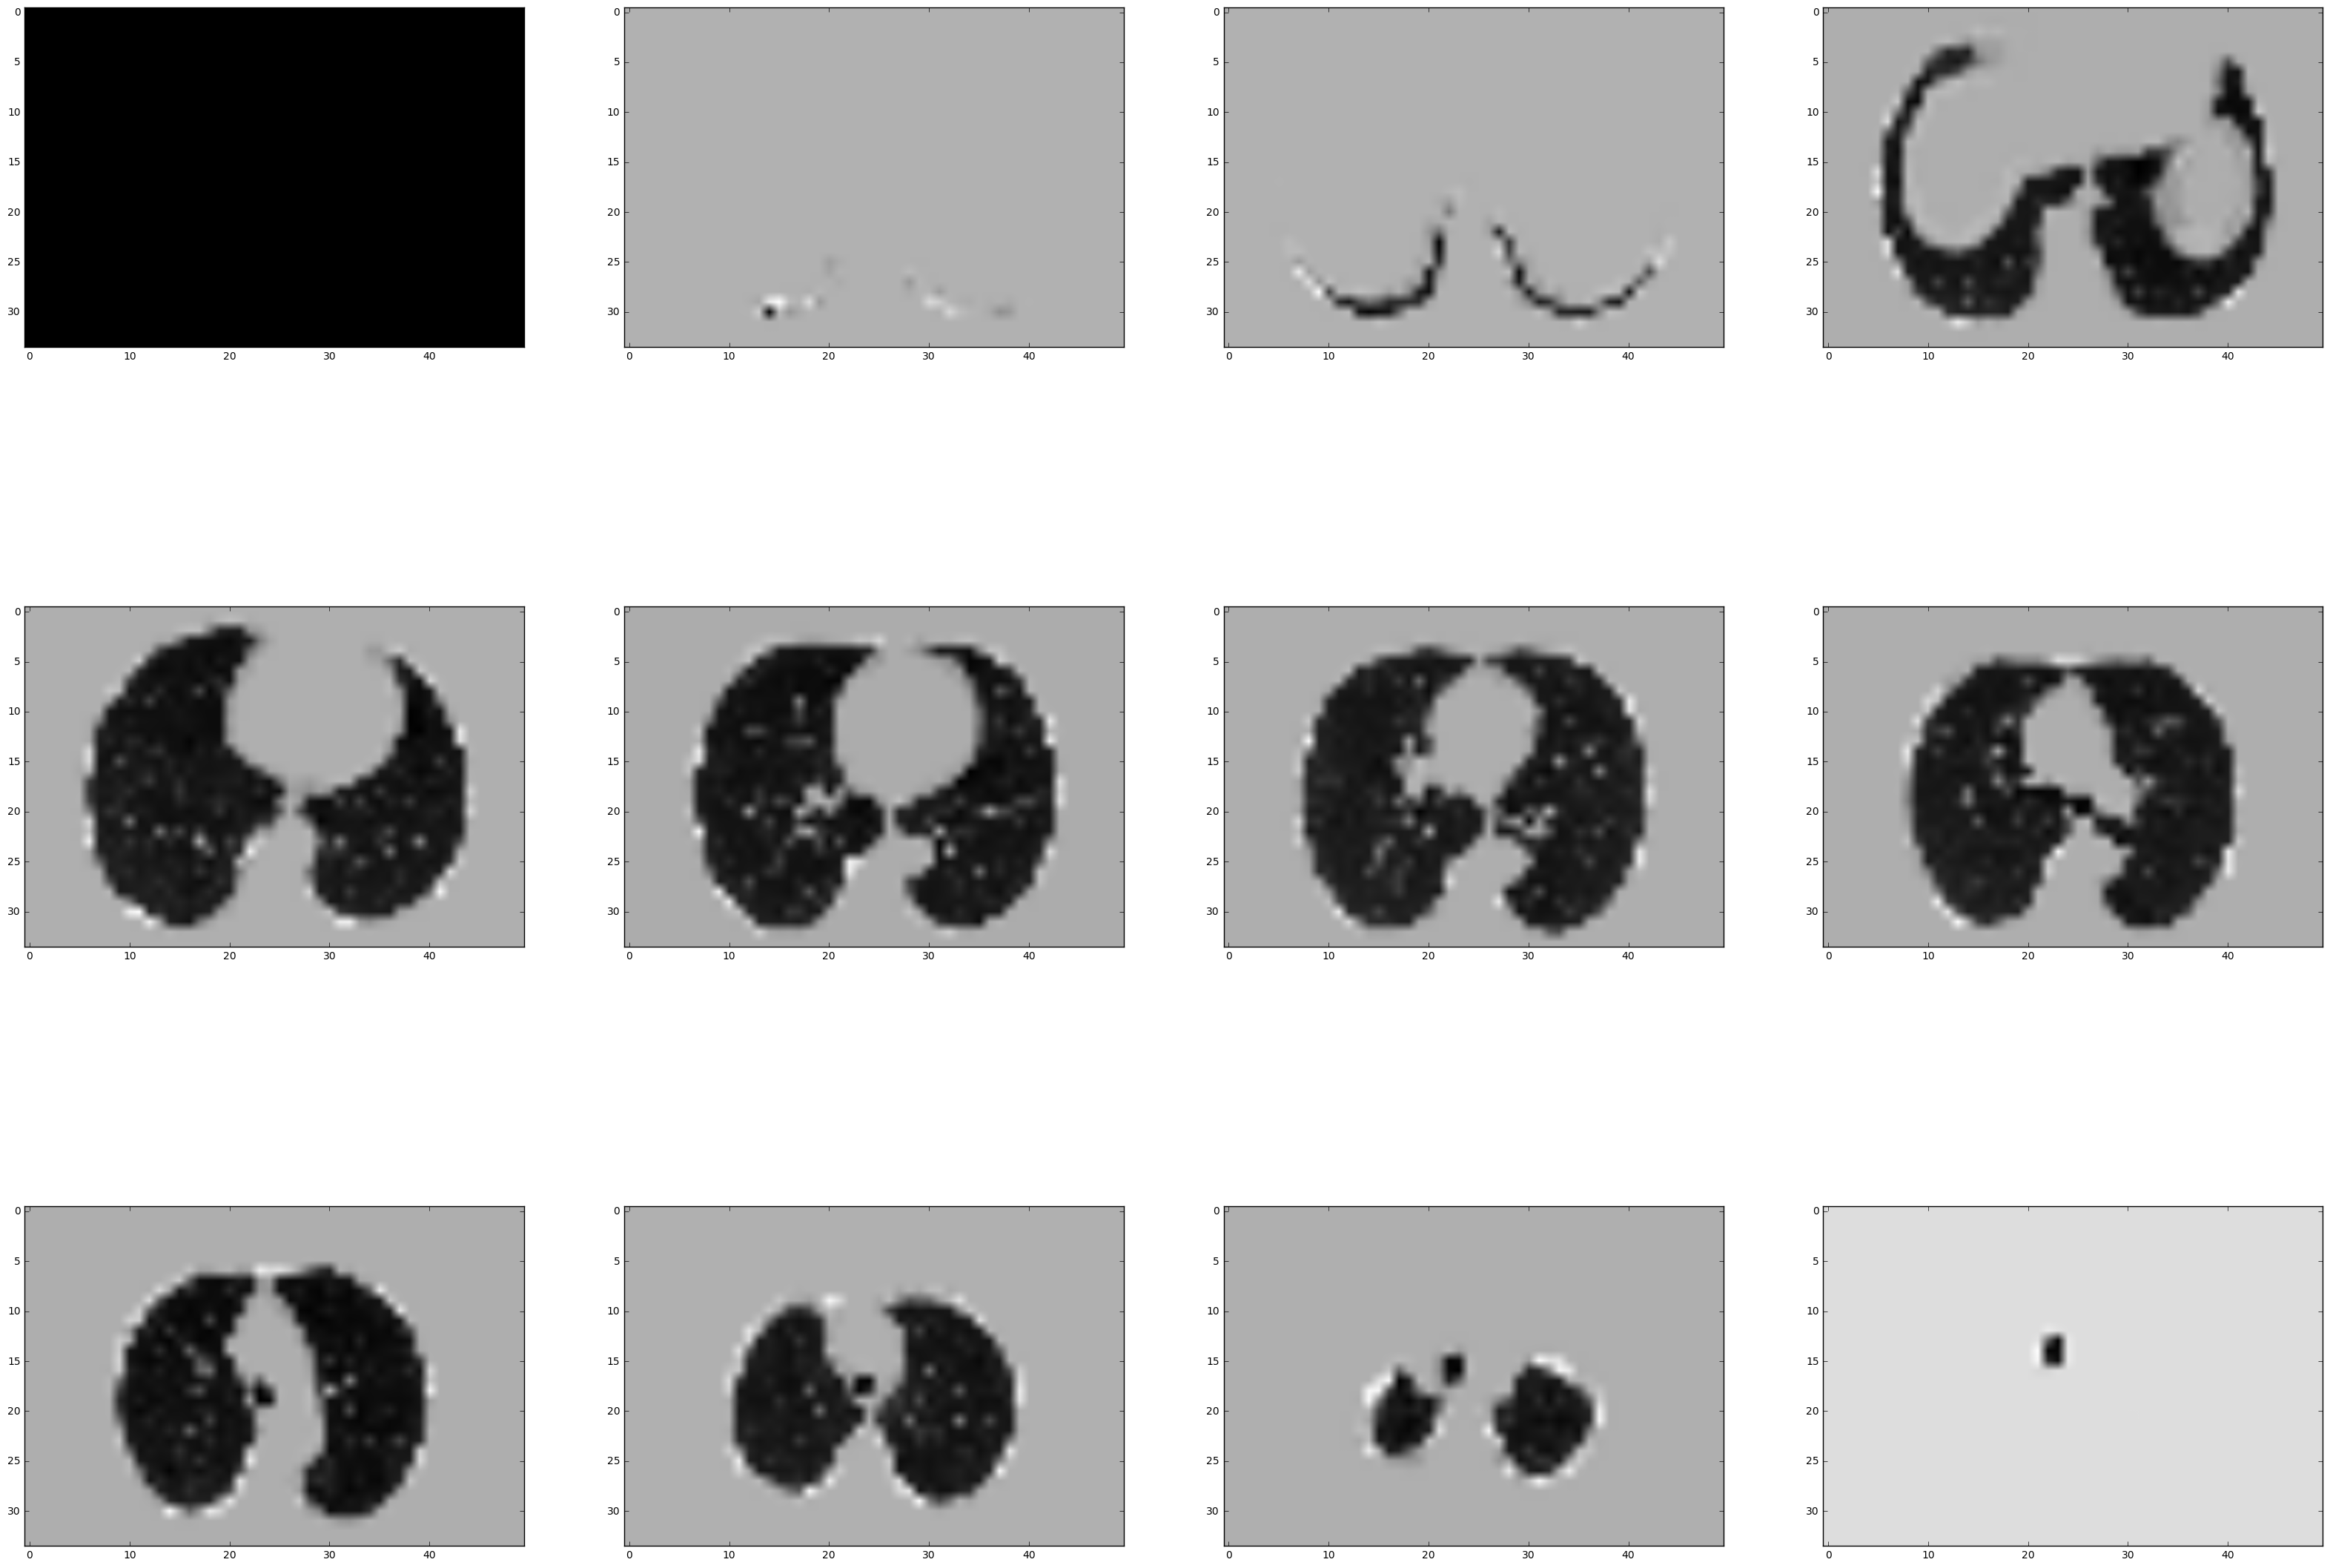

2017-02-21 04:24:40,397 INFO y=[ 1.  0.]
2017-02-21 04:24:40,399 INFO > [done]    Distribute to test dataset (56520.691 ms)
2017-02-21 04:24:40,400 INFO ==== ALL DONE ====


In [10]:
logger.info('==== PROCESSING SHARDS MERGE ====')
start_processing(INPUT_FOLDER, INPUT_IMAGE_DIMS, OUTPUT_IMAGE_DIMS, OUTPUT_FOLDER)
logger.info('==== ALL DONE ====')